# World Data League 2021

## Introduction

The aging of the population has become a global phenomenon and it’s expected that, in 2050, 22% of the world population has 60 or more years. Thus, several challenges arise in the way that society and cities should evolve to address new needs, in terms of basic services, infrastructures, urban design and transport services. [1]

Due to the consequences of aging, such as the loss of functional capacities, the elderly's mobility becomes one of the focuses when planning cities. Therefore it’s necessary to provide adequate access to public transports since it’s the best way to supply their basic needs and allow them to connect to people and places, which encompasses a good quality of life.

According to literature some of the reasons that affect the use of public transport in elderly are related to: age, regular income, distance from home, independence in mobility, travel time, activity time, residential location, destination type, weather and quality of transport and stops.[1][2]

In this project, we intend to find out which variables mainly influence the mobility and the use of buses by the elderly, and create a model, based on these variables, that is capable of predicting the number of elderly people who use buses daily. We believe that this information will be crucial in the way cities can evolve to make life easier for the elderly population.

Taking into account that the given data only have the county of origin and not the destination, some of the previous reasons are not applicable, such as the travel time, activity time, destination type, and distance from home. Thus, we decided to only focus on the types of data that are related to the county of origin. 

Some variables that we consider relevant and found available were:
- the number of senior residents older than 65 years old, which allows us to calculate the percentage of elderly using buses daily; [3]
- the aging index, that expresses the relationship between young and elder people; [4]
- the purchasing power, that can be related to the cost and quality of life; [5]
- the number of crimes per thousand inhabitants; [6]
- the dependence index of seniors, because the greater the dependency the less the ability to use public transports; [7]
- the weather, that according to the literature the precipitation leads to the non-use of buses. [8]

Lastly, we also decided to analyze the existing services in the municipalities, in particular what other services related to mobility and transportation exists, and the impact of them in the average daily senior population travelling by public transportation.

## Development

First things first, we started by exploring the given data to understand which variables are involved and which relationships can be highlighted from the beginning.

In [ ]:
!pip install --upgrade osmium

Requirement already up-to-date: osmium in /usr/local/lib/python3.7/dist-packages (3.1.3)


In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import requests
import pickle 
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
import osmium

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
file_loc = 'https://raw.githubusercontent.com/anafsa/ChildrenOfJupyterDatasets/main/Stage-1/challenge2/'

In [3]:
df = pd.read_csv(file_loc+'BusRoutes.txt', sep='|')

## Bus routes

In [4]:
print("\nUnique Routes and Links: \n" + str(df.nunique(axis=0)))
print("\n")
df.head()


Unique Routes and Links: 
IDRoute      166
linkid     19277
dtype: int64




,IDRoute,linkid
0,1,537277300
1,1,537277673
2,1,537277754
3,1,537277777
4,1,537277795


## Links per Bus Route (e.g, road)

In [5]:
dfRoutesLinkCount = df.groupby('IDRoute', as_index=False)['linkid'].count().rename(columns={'linkid':'Number of Links'}).sort_values("Number of Links", ascending=False) 
dfRoutesLinkCount.head()

,IDRoute,Number of Links
52,53,613
7,8,608
135,136,585
127,128,572
62,63,565


## Bus Routes per Link  

In [6]:
dfLinkRoutesCount = df.groupby('linkid', as_index=False)['IDRoute'].count().rename(columns={'IDRoute':'RoutesNumber'}).sort_values("RoutesNumber", ascending=False) 
dfLinkRoutesCount.head()

,linkid,RoutesNumber
6679,724627591,20
15464,1172432839,20
6678,724627590,20
9401,836110932,20
6676,724627588,20


## Most links are used by few routes 

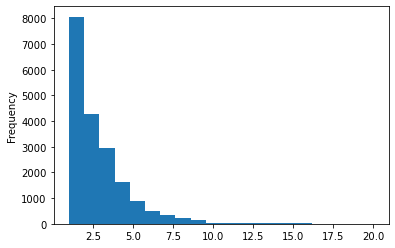

In [7]:
dfLinkRoutesCount.RoutesNumber.plot.hist(bins=20);

## Possible "stroke" points (Links with too many routes going through them)

In [8]:
dfSenior = pd.read_csv(file_loc + 'Senior_TIM_v1.txt', sep='|', encoding= 'unicode_escape')

In [9]:
joinedDf=dfSenior.merge(df)
joinedDf.head()

,linkid,Region_of_Origin,District_of_Origin,County_of_Origin,Average_Daily_SeniorPopulation_Travelling,IDRoute
0,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187,8
1,80216810,R1 - AM Lisboa,Lisboa,Lisboa,2013.681187,85
2,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396,8
3,80216810,R1 - AM Lisboa,Setúbal,Palmela,7688.296396,85
4,80216810,R1 - AM Lisboa,Lisboa,Oeiras,220.647248,8


## Links/Routes per Region, District and County

In [10]:
joinedDf.groupby("Region_of_Origin").agg({'linkid': 'nunique', 'IDRoute': 'nunique', 'Average_Daily_SeniorPopulation_Travelling': 'mean'}) \
                                   .rename(columns={'linkid':'NumberOfLinks', 'IDRoute':'NumberOfRoutes', 'Average_Daily_SeniorPopulation_Travelling': 'AvgDailyPopulation'}) \
                                   .sort_values("NumberOfLinks", ascending=False) 

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation
Region_of_Origin,,,
R1 - AM Lisboa,6184,160,576.977871
R2 - AM Porto,3803,133,2435.724436


In [11]:
joinedDf.groupby("District_of_Origin").agg({'linkid': 'nunique', 'IDRoute': 'nunique', 'Average_Daily_SeniorPopulation_Travelling': 'mean'}) \
                                   .rename(columns={'linkid':'NumberOfLinks', 'IDRoute':'NumberOfRoutes', 'Average_Daily_SeniorPopulation_Travelling': 'AvgDailyPopulation'}) \
                                   .sort_values("NumberOfLinks", ascending=False) 

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation
District_of_Origin,,,
Lisboa,5916,158,628.158972
Porto,3777,133,2451.672828
Setúbal,2368,141,365.034285
Aveiro,32,16,272.407024


In [12]:
linksRoutesPerOrigin=joinedDf.groupby(["District_of_Origin", "County_of_Origin"]).agg({'linkid': 'nunique', 'IDRoute': 'nunique', 'Average_Daily_SeniorPopulation_Travelling': 'mean'}) \
                                   .rename(columns={'linkid':'NumberOfLinks', 'IDRoute':'NumberOfRoutes', 'Average_Daily_SeniorPopulation_Travelling': 'AvgDailyPopulation'}) \
                                   .sort_values(["District_of_Origin", "AvgDailyPopulation"], ascending=[True,  False]) 

linksRoutesPerOrigin

NumberOfLinks  NumberOfRoutes  \
District_of_Origin County_of_Origin                                      
Aveiro             Santa Maria da Feira             32              16   
Lisboa             Lisboa                         3832             132   
                   Odivelas                       1255             120   
                   Oeiras                         2824             152   
                   Vila Franca de Xira            1929             100   
                   Sintra                         1226             107   
                   Cascais                         472              98   
                   Amadora                         613              92   
                   Mafra                           283              81   
                   Loures                          141              51   
Porto              Maia                           2670              99   
                   Porto                          1478             110   
                   Gondomar                       1076              95   
                   Matosinhos                      195              33   
Setúbal            Palmela                         240              68   
                   Alcochete                         6               8   
                   Montijo                          55              15   
                   Barreiro                       1285             119   
                   Seixal                          942             110   
                   Setúbal                         113              29   
                   Sesimbra                         49              24   
                   Almada                          131              44   

                                         AvgDailyPopulation  
District_of_Origin County_of_Origin                          
Aveiro             Santa Maria da Feira          272.407024  
Lisboa             Lisboa                       1176.641628  
                   Odivelas                      715.200512  
                   Oeiras                        394.144009  
                   Vila Franca de Xira           364.993711  
                   Sintra                        351.236967  
                   Cascais                       285.334270  
                   Amadora                       155.706508  
                   Mafra                         144.367737  
                   Loures                        141.271239  
Porto              Maia                         3400.213919  
                   Porto                        2213.490123  
                   Gondomar                     1084.179459  
                   Matosinhos                    823.843490  
Setúbal            Palmela                       889.849297  
                   Alcochete                     544.140508  
                   Montijo                       441.206994  
                   Barreiro                      346.062201  
                   Seixal                        329.882526  
                   Setúbal                       138.546544  
                   Sesimbra                      116.808277  
                   Almada                         40.539317

The number of routes and links in the region 'R1 - AM Lisboa' is greater than in the region 'R2 – AM Porto', however the average daily population (AVG) is higher in the second one.

Considering the district of origin, that relationship does not always occur because in Lisboa the number of routes and links is greater than in Setúbal such as the AVG. Nevertheless, looking at Aveiro and Setúbal, where the number of links and routes have big dimensional differences, the AVG is very similar.

Hereby, we can conclude that the region R1 (Lisboa and Setúbal) and R2 (Porto and Aveiro) have different behaviors.


## Distribution of links

<AxesSubplot:>

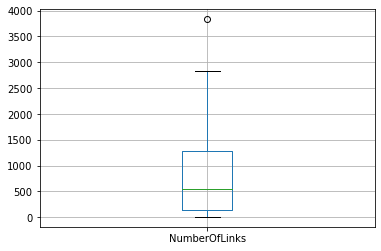

In [13]:
linksRoutesPerOrigin.boxplot('NumberOfLinks')

<AxesSubplot:ylabel='Frequency'>

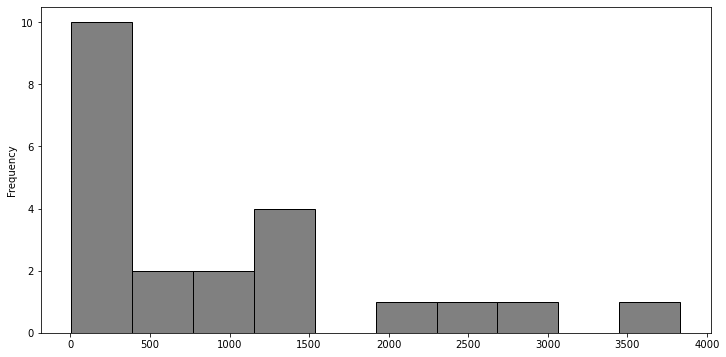

In [14]:
linksRoutesPerOrigin['NumberOfLinks'].plot(kind='hist', bins=10, figsize=(12,6), facecolor='grey',edgecolor='black')

Looking at the above histogram, we can observe that most counties have less than 2 thousand links.

## Distribution of routes

<AxesSubplot:>

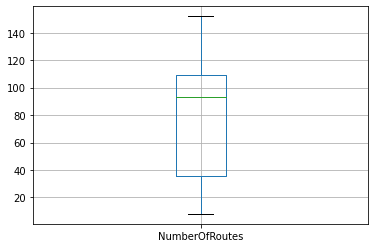

In [15]:
linksRoutesPerOrigin.boxplot('NumberOfRoutes')

<AxesSubplot:ylabel='Frequency'>

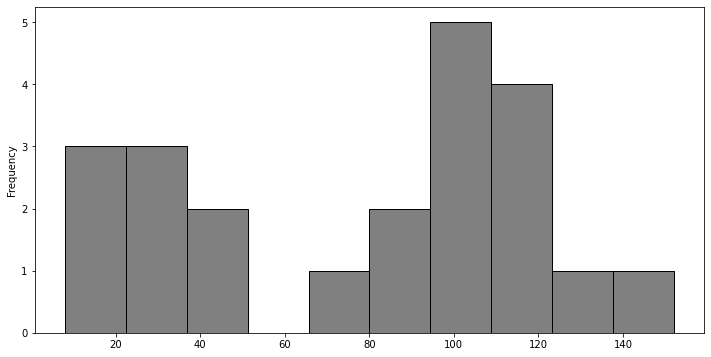

In [16]:
linksRoutesPerOrigin['NumberOfRoutes'].plot(kind='hist', bins=10, figsize=(12,6), facecolor='grey',edgecolor='black')

Analyzing the histogram, we can conclude that the frequency is higher around 100 and 120 and then the next most frequent values are lower than 60.

## Distribution of Average Daily Senior Population

<AxesSubplot:>

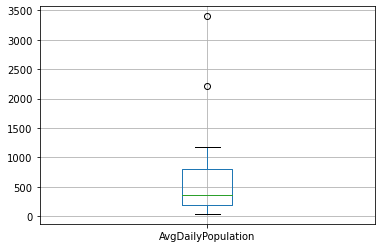

In [17]:
linksRoutesPerOrigin.boxplot('AvgDailyPopulation')

<AxesSubplot:ylabel='Frequency'>

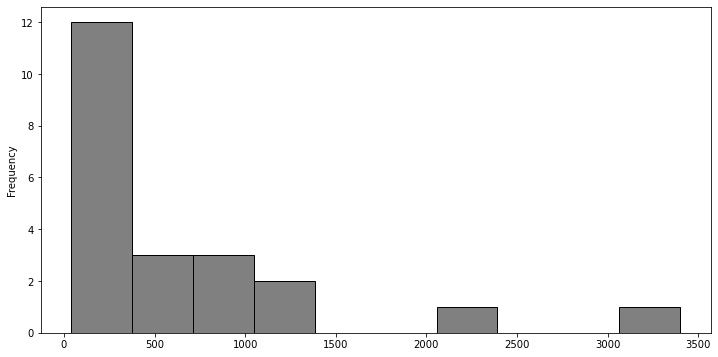

In [18]:
linksRoutesPerOrigin['AvgDailyPopulation'].plot(kind='hist', bins=10, figsize=(12,6), facecolor='grey',edgecolor='black')

For the average daily population, the majority of counties has less than 1500 senior people daily travelling.

## Open Weather Analysis

We will analyze whether the weather and air polution influences senior citizens to use public transports 

In [19]:
conversion_dic= {
    "Porto": "Porto",
    "Aveiro": "Aveiro",
    "Lisboa": "Lisbon",
    "Setúbal": "Setubal"
}

def get_lat_lon(district_name, city_name):
    print("Retrieving Lat and Long of {0} ({1})...".format(city_name, district_name))

    # If no city name is available then use district instead
    if city_name in conversion_dic:
        city_name=conversion_dic[city_name]
    
    url = "http://api.openweathermap.org/geo/1.0/direct?q=" + city_name + "&appid=155b4d6acbf49ae8044c54f654953578"

    request_json=requests.get(url).json()
    if len(request_json)==0:
        return get_history(district_name, district_name)
        
    return (request_json[0]["lat"], request_json[0]["lon"])


def get_air_polution(lat, lon, metric):
    print("Retrieving {0} ({1}) air polution...".format(lat, lon))
    
    url = "http://api.openweathermap.org/data/2.5/air_pollution?lat={0}&lon={1}&appid=155b4d6acbf49ae8044c54f654953578".format(lat, lon)

    request_json=requests.get(url).json()
        
    if metric==None:
        return request_json["list"][0]["main"]["aqi"]
    else:
        return request_json["list"][0]["components"][metric]
    
def get_history(district_name, city_name):
    print("Retrieving {0} ({1}) history...".format(city_name, district_name))

    # If no city name is available then use district instead
    if city_name in conversion_dic:
        city_name=conversion_dic[city_name]
    
    url = "http://history.openweathermap.org/data/2.5/aggregated/year?q=" + city_name + ",PT&appid=" + "155b4d6acbf49ae8044c54f654953578" \
                + "&start=2019-04-01" \
                + "&end=2020-03-31" \

    request_json=requests.get(url).json()
    if "result" not in request_json:
        return get_history(district_name, district_name)
        
    return pd.json_normalize(request_json["result"])

def get_agg_metric(district, city, col, agg_metric):
    df=get_history(district, city)
    return df.agg({col: agg_metric})[0] 

Retrieve weather and air polution data from OpenWeather API

In [21]:
def apply_func(district_name, city_name, metric):
    lat_lon = get_lat_lon(district_name, city_name)
    return get_air_polution(lat_lon[0], lat_lon[1], metric)


linksRoutesPerOrigin['AvgYearTemp'] = linksRoutesPerOrigin.apply(lambda row: get_agg_metric(row.name[0], row.name[1], "temp.mean", "mean"), axis=1)
linksRoutesPerOrigin['AvgYearPrecipitation'] = linksRoutesPerOrigin.apply(lambda row: get_agg_metric(row.name[0], row.name[1], "precipitation.mean", "mean"), axis=1)
linksRoutesPerOrigin['CO2Concentration'] = linksRoutesPerOrigin.apply(lambda row: apply_func(row.name[0], row.name[1], "co"), axis=1)
linksRoutesPerOrigin['pm2_5Concentration'] = linksRoutesPerOrigin.apply(lambda row: apply_func(row.name[0], row.name[1], "pm2_5"), axis=1)
linksRoutesPerOrigin['pm10Concentration'] = linksRoutesPerOrigin.apply(lambda row: apply_func(row.name[0], row.name[1], "pm10"), axis=1)
linksRoutesPerOrigin['AirQuality'] = linksRoutesPerOrigin.apply(lambda row: apply_func(row.name[0], row.name[1], None), axis=1)

Retrieving Santa Maria da Feira (Aveiro) history...
Retrieving Aveiro (Aveiro) history...
Retrieving Lisboa (Lisboa) history...
Retrieving Odivelas (Lisboa) history...
Retrieving Oeiras (Lisboa) history...
Retrieving Lisboa (Lisboa) history...
Retrieving Vila Franca de Xira (Lisboa) history...
Retrieving Sintra (Lisboa) history...
Retrieving Cascais (Lisboa) history...
Retrieving Amadora (Lisboa) history...
Retrieving Mafra (Lisboa) history...
Retrieving Loures (Lisboa) history...
Retrieving Maia (Porto) history...
Retrieving Porto (Porto) history...
Retrieving Gondomar (Porto) history...
Retrieving Matosinhos (Porto) history...
Retrieving Palmela (Setúbal) history...
Retrieving Alcochete (Setúbal) history...
Retrieving Montijo (Setúbal) history...
Retrieving Barreiro (Setúbal) history...
Retrieving Seixal (Setúbal) history...
Retrieving Setúbal (Setúbal) history...
Retrieving Setúbal (Setúbal) history...
Retrieving Sesimbra (Setúbal) history...
Retrieving Almada (Setúbal) history...
R

Retrieving Lat and Long of Lisboa (Lisboa)...
Retrieving 38.7167 (-9.1333) air polution...
Retrieving Lat and Long of Odivelas (Lisboa)...
Retrieving 38.7927 (-9.1838) air polution...
Retrieving Lat and Long of Oeiras (Lisboa)...
Retrieving -7.0253 (-42.1311) air polution...
Retrieving Lat and Long of Vila Franca de Xira (Lisboa)...
Retrieving 38.9553 (-8.9897) air polution...
Retrieving Lat and Long of Sintra (Lisboa)...
Retrieving 38.801 (-9.3783) air polution...
Retrieving Lat and Long of Cascais (Lisboa)...
Retrieving 38.6979 (-9.4215) air polution...
Retrieving Lat and Long of Amadora (Lisboa)...
Retrieving 38.7538 (-9.2308) air polution...
Retrieving Lat and Long of Mafra (Lisboa)...
Retrieving -26.1114 (-49.8053) air polution...
Retrieving Lat and Long of Loures (Lisboa)...
Retrieving 38.8309 (-9.1685) air polution...
Retrieving Lat and Long of Maia (Porto)...
Retrieving 41.2357 (-8.6199) air polution...
Retrieving Lat and Long of Porto (Porto)...
Retrieving 41.1496 (-8.611) air

## Correlation Matrix (Globally)

Let's now check if there are any correlations between the previous variables and the weather/air polution data

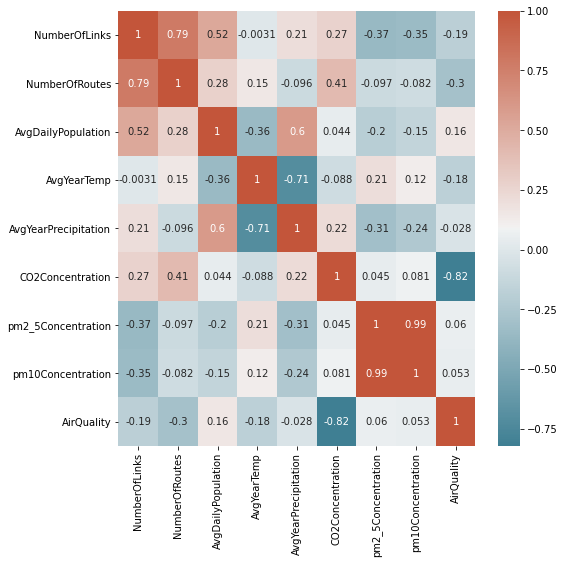

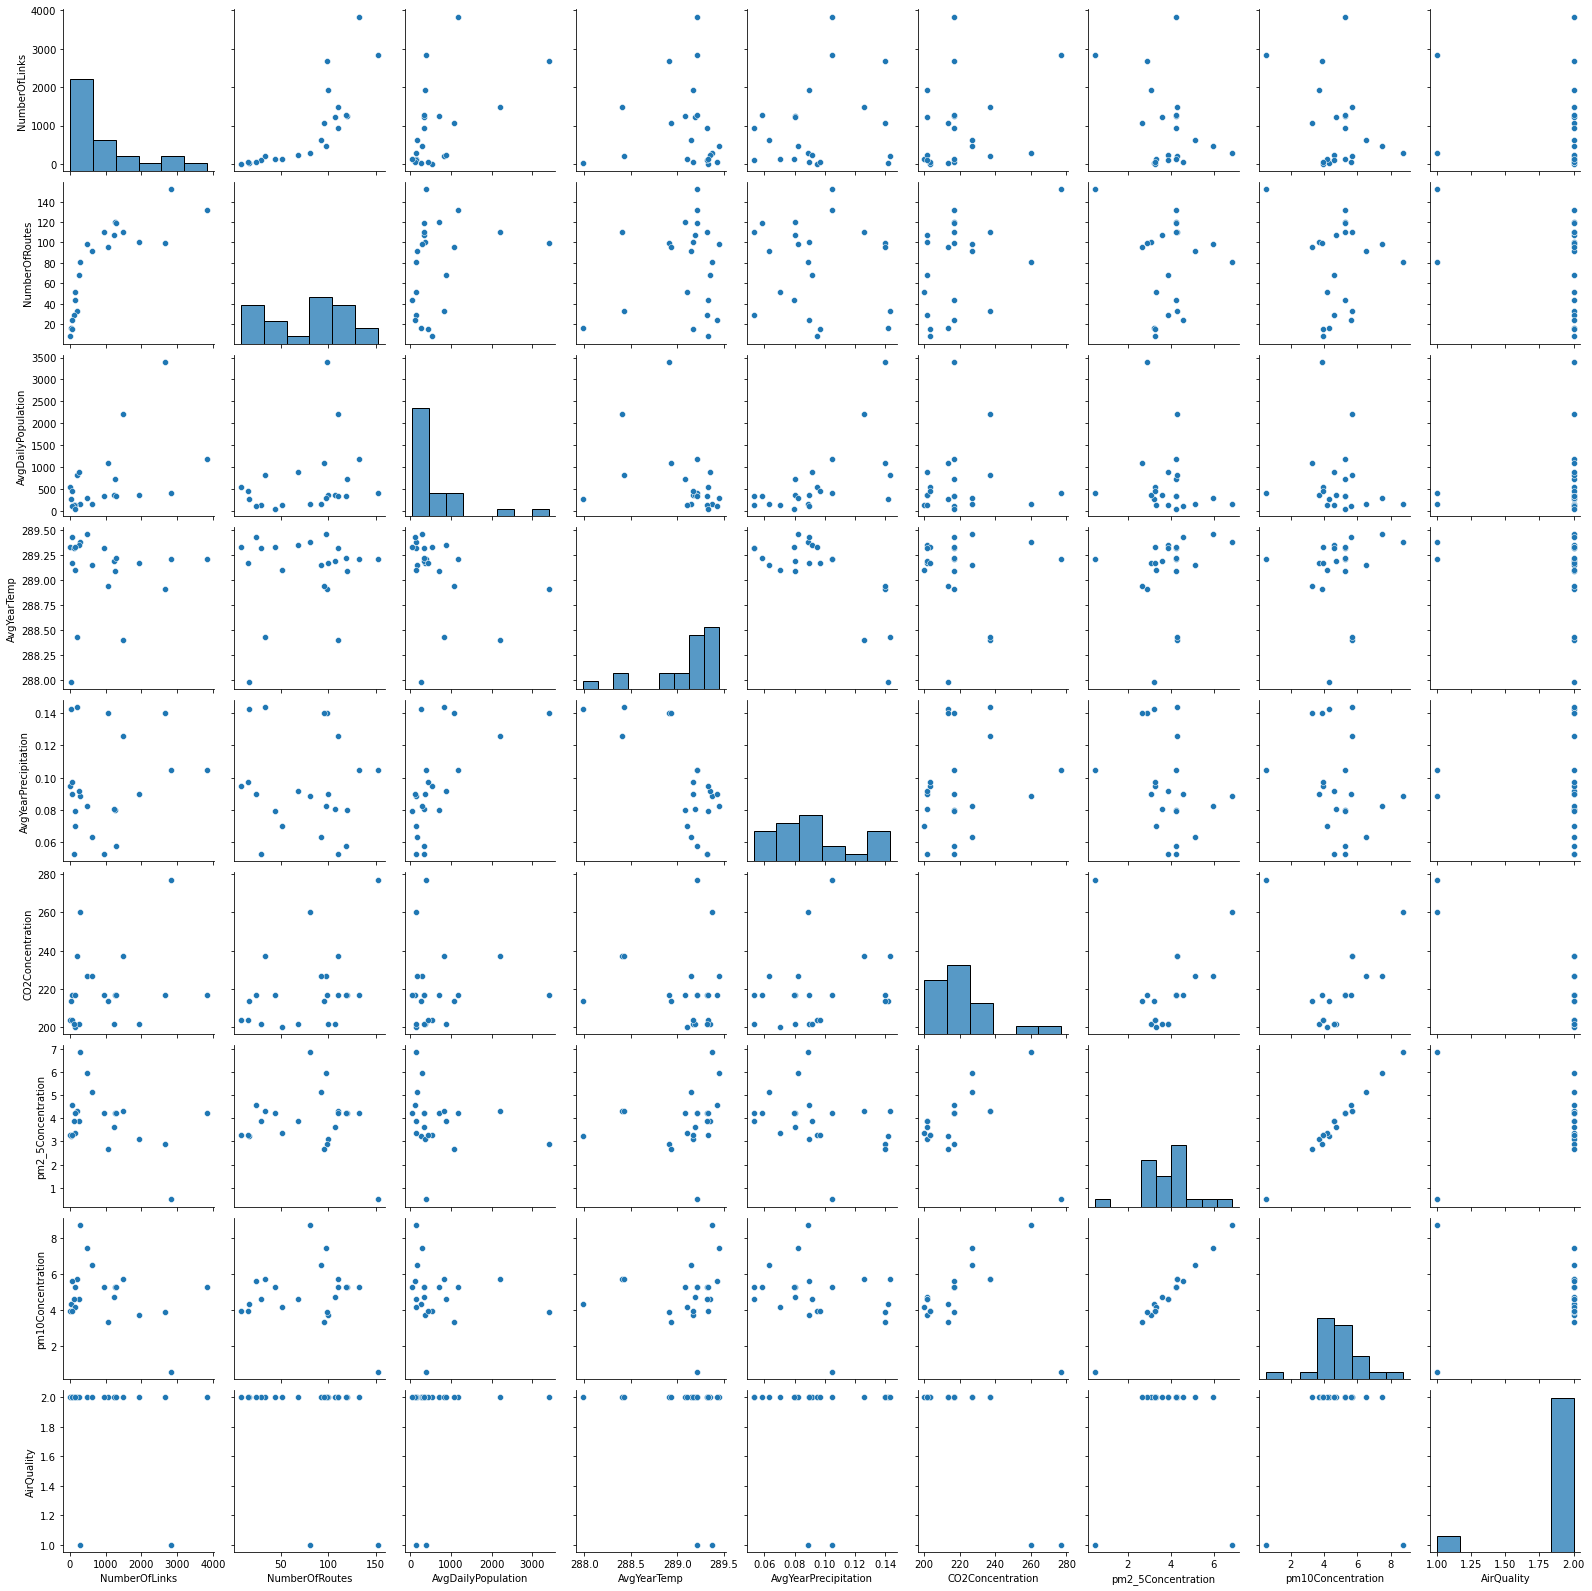

In [22]:
corr = linksRoutesPerOrigin.corr()

fig, ax = plt.subplots(figsize=(8,8))        

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax)
sns.pairplot(linksRoutesPerOrigin)

From the above correlation matrix is possible to deduce that the number of links is correlated to the number of routes.
The average of anual precipitation is very correlated with the 
average daily senior population. This may indicate that citizens that would otherwise
walk prefer to use public transports.

There is also inversion correlation between air quality and average year temperature
Co2 has a correlation with the number of routes, meaning that more routes 
can lead to more vehicles in circulation.

However, our main goal is to understand which variable mainly influences AvgDailySeniorPopulation, so next, we analyze the cities separately.

## Correlation Matrix (per District)

In [23]:
def study_per_city(df, city):
  corr = df.filter(like = city, axis=0).corr()# plot the heatmap
  fig, ax = plt.subplots(figsize=(8,8))        

  sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax)
  sns.pairplot(df.filter(like = city, axis=0))

#### Porto

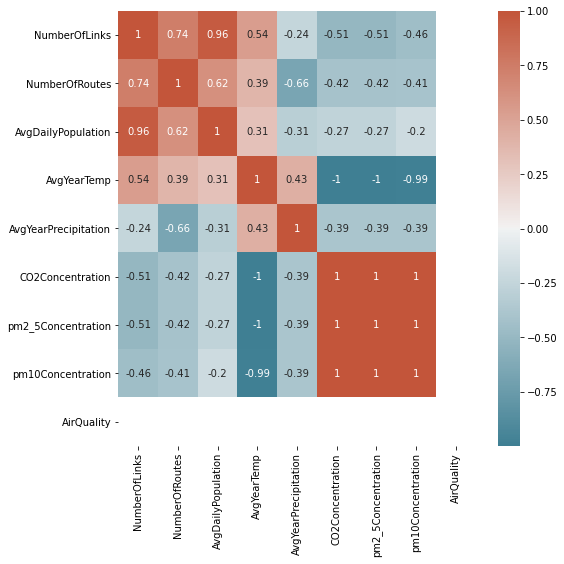

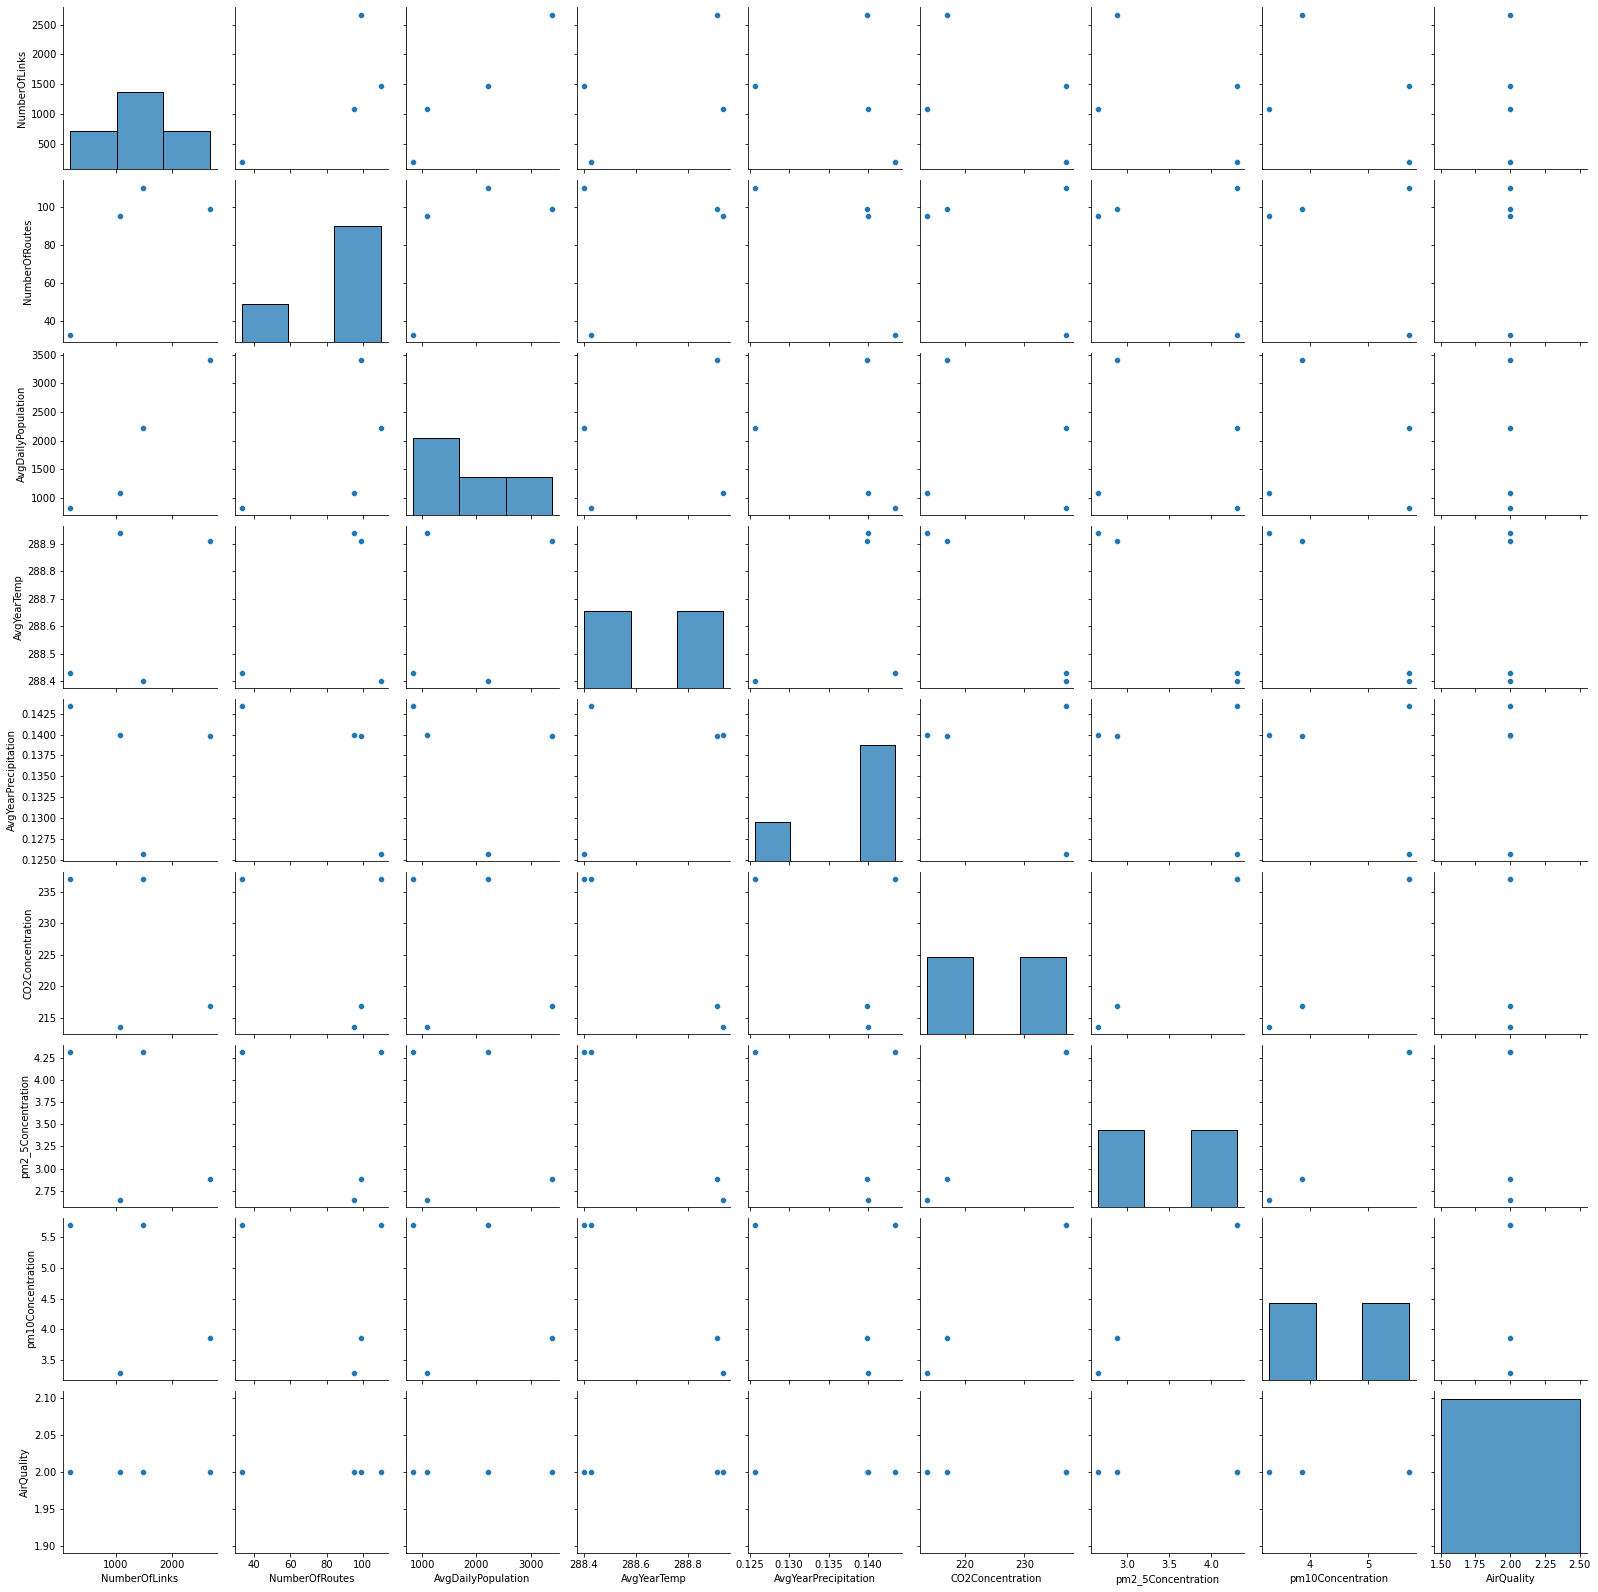

In [24]:
study_per_city(linksRoutesPerOrigin, 'Porto')

#### Lisboa

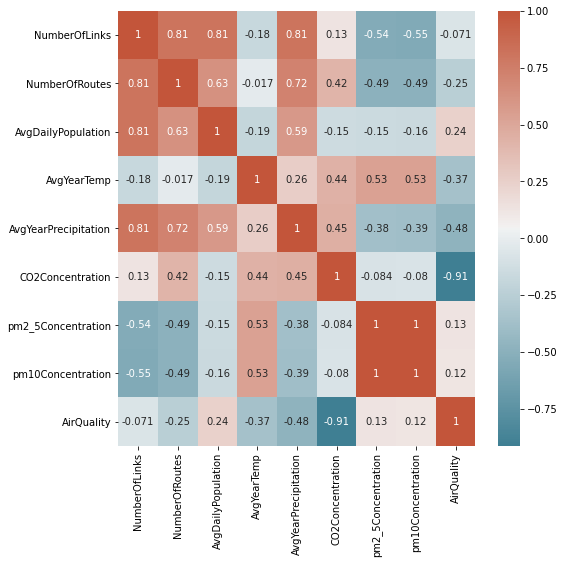

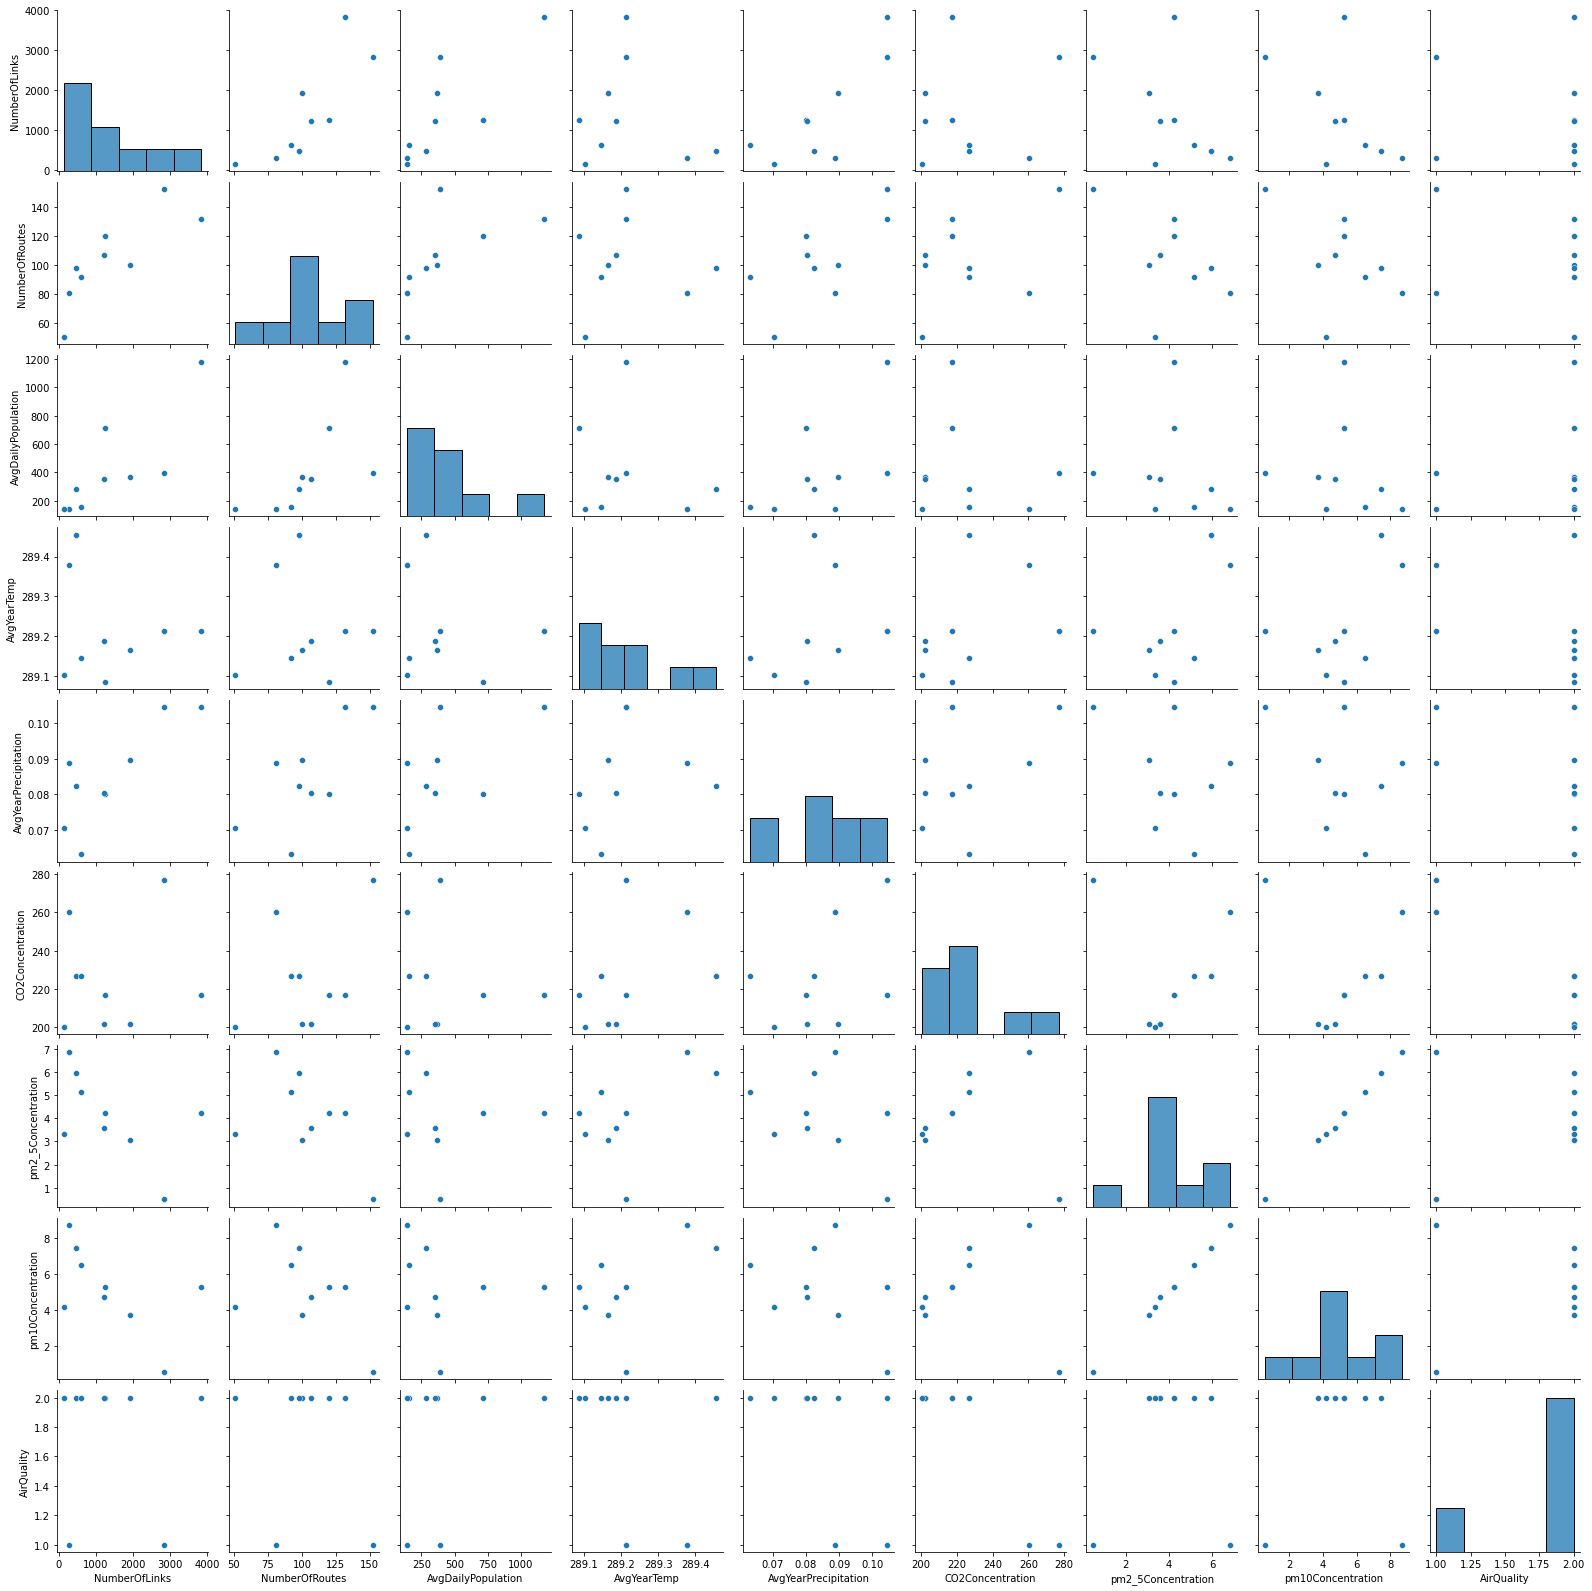

In [25]:
study_per_city(linksRoutesPerOrigin, 'Lisboa')

#### Setúbal

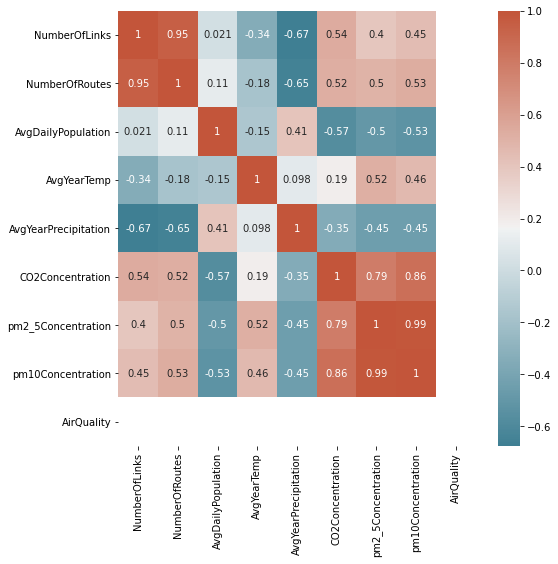

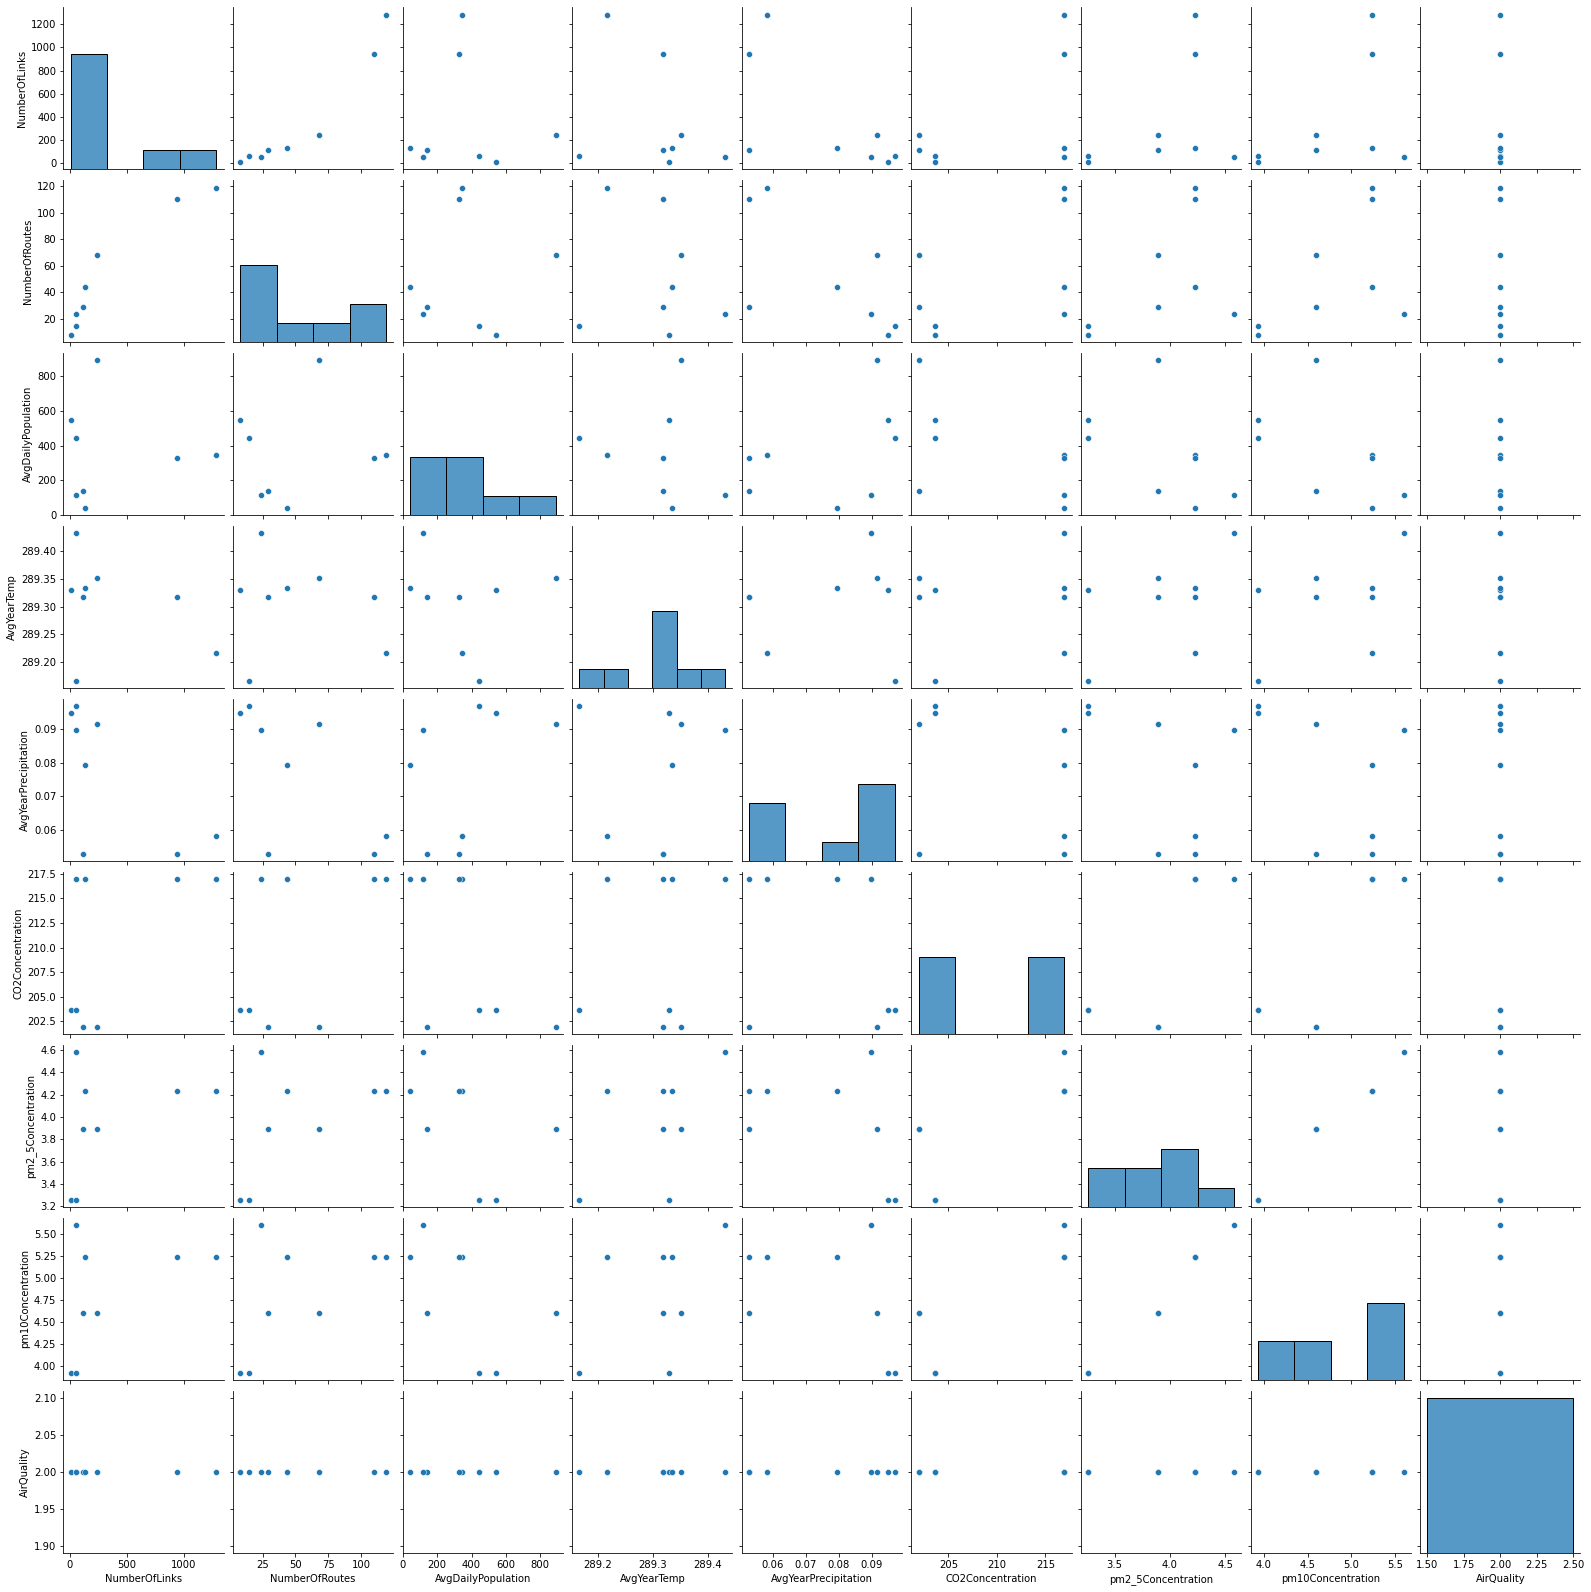

In [26]:
study_per_city(linksRoutesPerOrigin, 'Setúbal')

The results from the different districts can be summarized by:
- in Porto, there is a big correlation between the number of links and ADSP;
- in Lisboa, there’s also a big correlation between the number of links and AVG, however smaller;
- in Setúbal, no correlation with AVG is evident.

## Use PyOsmium to get Amenities Information
Here we get Amenities Information from some districts based on the code presented in Workshop \#2 

We use only Lisbon and Porto because they are the only districts available at the [OSM Ready Extracts](https://download.bbbike.org/osm/bbbike/)

In [27]:
from collections import defaultdict

class AmenityStatsHandler(osmium.SimpleHandler):
    def __init__(self):
        super(AmenityStatsHandler, self).__init__()
        self.amenities = defaultdict(int)
    
    def node(self, n):
        for tag in n.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

    def way(self, w):
        for tag in w.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

    def relation(self, r):
        for tag in r.tags:
            if tag.k == 'amenity':
                self.amenities[tag.v] += 1

Download OpenStreetMap Extract

In [28]:
%%bash

FILE=Lisbon.osm.pbf
if  [[ -f "$FILE" ]]; then
    echo "$FILE already present."
else
    wget https://download.bbbike.org/osm/bbbike/Lisbon/Lisbon.osm.pbf \
    --quiet -O Lisbon.osm.pbf
fi

FILE=Porto.osm.pbf
if  [[ -f "$FILE" ]]; then
    echo "$FILE already present."
else
    wget https://download.bbbike.org/osm/bbbike/Porto/Porto.osm.pbf \
    --quiet -O Porto.osm.pbf
fi

In [29]:
src_filepath_lisboa = "Lisbon.osm.pbf"

handler_lisboa = AmenityStatsHandler()
handler_lisboa.apply_file(src_filepath_lisboa)

s_amenities_lisboa = pd.Series(handler_lisboa.amenities)

In [30]:
src_filepath_porto = "Porto.osm.pbf"

handler_porto = AmenityStatsHandler()
handler_porto.apply_file(src_filepath_porto)
s_amenities_porto = pd.Series(handler_porto.amenities)

In [31]:
#keep only certain amenities, namely the ones relating to mobility services or utilities:
mobility_amenities = ["bus_station", "ticket_validator", "motorcycle_parking", "parking", "parking_space", "taxi",\
"bicycle_rental", "bicycle_rental"]

#transform lisbon pd series to dataframe and keep only certain amenities
amenities_lisboa_df = pd.DataFrame({'amenity':s_amenities_lisboa.index, 'count':s_amenities_lisboa.values})
amenities_lisboa_df=amenities_lisboa_df[amenities_lisboa_df['amenity'].isin(mobility_amenities)]

#transform porto pd series to dataframe and keep only certain amenities
amenities_porto_df = pd.DataFrame({'amenity':s_amenities_porto.index, 'count':s_amenities_porto.values})
amenities_porto_df=amenities_porto_df[amenities_porto_df['amenity'].isin(mobility_amenities)]

#merge the 2 dataframes
amenities_lisboa_porto_df = pd.merge(left=amenities_lisboa_df, right=amenities_porto_df, how='left', left_on='amenity', right_on='amenity')
amenities_lisboa_porto_df.columns = ["amenity", "lisbon_count", "porto_count"]
amenities_lisboa_porto_df.head(10)

,amenity,lisbon_count,porto_count
0,parking,15652,4593
1,bus_station,70,44
2,taxi,113,71
3,bicycle_rental,168,16
4,parking_space,88,54
5,motorcycle_parking,80,3
6,ticket_validator,80,8


In [41]:
avg_sen_district_df = joinedDf.groupby("District_of_Origin").agg({'linkid': 'nunique', 'IDRoute': 'nunique', 'Average_Daily_SeniorPopulation_Travelling': 'mean'}) \
                                   .rename(columns={'linkid':'NumberOfLinks', 'IDRoute':'NumberOfRoutes', 'Average_Daily_SeniorPopulation_Travelling': 'AvgDailyPopulation'}) \
                                   .sort_values("NumberOfLinks", ascending=False)
avg_sen_district_df.head(10)

,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation
District_of_Origin,,,
Lisboa,5916,158,628.158972
Porto,3777,133,2451.672828
Setúbal,2368,141,365.034285
Aveiro,32,16,272.407024


In [43]:
amenities_seniors_df = pd.DataFrame(None, columns = ['District']+list(amenities_lisboa_porto_df.amenity.values))
amenities_seniors_df.loc[len(amenities_seniors_df)] = ['Lisboa']+list(amenities_lisboa_porto_df.lisbon_count.values)
amenities_seniors_df.loc[len(amenities_seniors_df)] = ['Porto']+list(amenities_lisboa_porto_df.porto_count.values)
amenities_seniors_df = pd.merge(left=amenities_seniors_df, right=avg_sen_district_df, how='left', left_on='District', right_on='District_of_Origin')

cols = amenities_seniors_df.columns.drop('District')
amenities_seniors_df[cols] = amenities_seniors_df[cols].apply(pd.to_numeric, errors='coerce')
amenities_seniors_df.head(40)

,District,parking,bus_station,taxi,bicycle_rental,parking_space,motorcycle_parking,ticket_validator,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation
0,Lisboa,15652,70,113,168,88,80,80,5916,158,628.158972
1,Porto,4593,44,71,16,54,3,8,3777,133,2451.672828


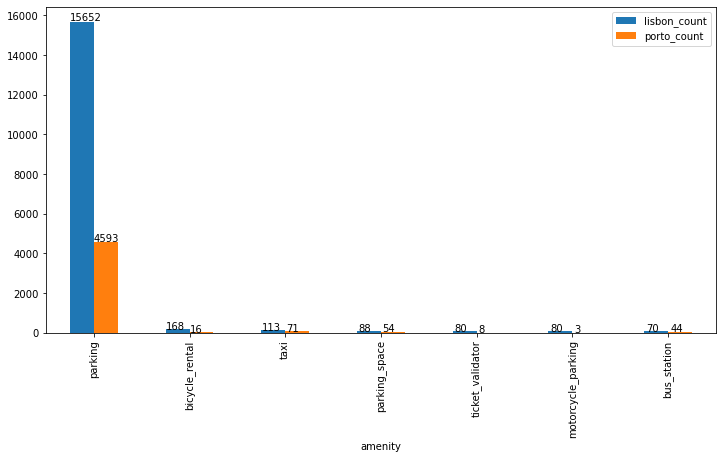

In [44]:
ax = amenities_lisboa_porto_df.sort_values(ascending=False, by=['lisbon_count', 'porto_count'])[:50] \
  .plot(kind='bar', figsize=(12, 6), x='amenity', y=["lisbon_count", "porto_count"]);
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

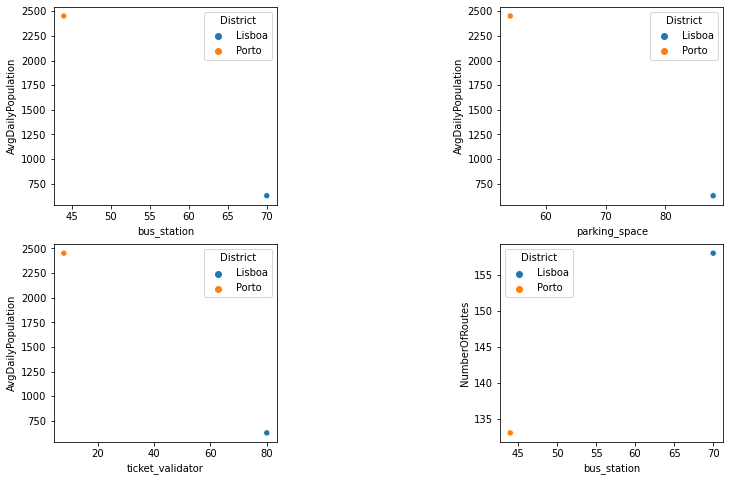

In [45]:
colors = {'Lisboa':'red', 'Porto':'blue'}


fig = plt.figure(2)

ax1 = fig.add_subplot(2, 2, 1)
sns.scatterplot(x='bus_station', y='AvgDailyPopulation', data=amenities_seniors_df, hue='District', ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
sns.scatterplot(x='parking_space', y='AvgDailyPopulation', data=amenities_seniors_df, hue='District', ax=ax2)
ax3 = fig.add_subplot(2, 2, 3)
sns.scatterplot(x='ticket_validator', y='AvgDailyPopulation', data=amenities_seniors_df, hue='District', ax=ax3)
ax4 = fig.add_subplot(2, 2, 4)
sns.scatterplot(x='bus_station', y='NumberOfRoutes', data=amenities_seniors_df, hue='District', ax=ax4)

fig.subplots_adjust(wspace=1)
fig.set_figheight(8)
fig.set_figwidth(12)

From here we can observe that even though Porto has less amenities such as bus stations, there are more seniors travelling on bus in Porto. A city with less stations or less ticket validators does not appear to negativelly impact the ammount of bus travellers. It can be concluded that more bus stations equals more bus routes. However, it would appear that more parking spaces could invite some seniors to either drive or have someone else give them a ride. Of course that more city amenity data would be necessary to validate this data


## Correlations between demographic data and ADSP

In this section, external data is analyzed in order to get other insights from the habits of the senior mobility.  Note that this data was preprocessed by us for easy manipulation, meaning that we are not using the original dataset as is.

In [46]:
def addInfo(df, file, varname, old_varname, cols_to_keep, convert=False):
    # get data from file
    newDf = pd.read_csv(file)[['local', old_varname]]
    
    newDf = newDf.rename(columns={old_varname: varname})
    
    # aggregate dataframes
    newDf = pd.merge(df, newDf, left_on="County_of_Origin", right_on='local')[cols_to_keep]
    
    if convert:
        newDf[varname]=newDf[varname].apply(lambda row: float(row.replace(",", ".")))    
    
    return newDf

## Check if dataframe CSV file is present locally, else build it (makes calls to open weather api and integrates datasets from Pordata)
aggDf = None
from pathlib import Path
full_df_csv_name = "aggregated_df.csv"
full_df_csv = Path(full_df_csv_name)
df_needs_building = True
if full_df_csv.is_file():
    # file exists
    df_needs_building = True
    aggDf = pd.read_csv(full_df_csv_name)  

# Remove index of linksRoutesPerOrigin
if df_needs_building:
  aggDf = linksRoutesPerOrigin
  aggDf = aggDf.reset_index()

# columns that I want to keep
cols_to_keep = aggDf.columns.to_list()

cols_to_keep.append('PurchPower17') # Add Purchasing power to columns that I want to keep
if df_needs_building:
  aggDf = addInfo(df=aggDf, file=file_loc+'local_purchasing_power.csv', varname='PurchPower17',old_varname='2017',
                cols_to_keep=cols_to_keep, convert=True)

cols_to_keep.append('DensPop19') # Add DensPop19 to columns that I want to keep
if df_needs_building:
  aggDf = addInfo(df=aggDf, file=file_loc+'pop_density.csv', varname='DensPop19',old_varname='2019',
                cols_to_keep=cols_to_keep, convert=True)

cols_to_keep.append('SeniorDepend19') # Add Senior Dependency to columns that I want to keep
if df_needs_building:
  aggDf = addInfo(df=aggDf, file=file_loc+'senior_citizen_dependency.csv', varname='SeniorDepend19', old_varname='2019',
             cols_to_keep=cols_to_keep)

# IndexEnvelh2019
cols_to_keep.append('OldAgeIdx19') # Add Old Age Index to columns that I want to keep
if df_needs_building:
  aggDf = addInfo(df=aggDf, file=file_loc+'age_index.csv', varname='OldAgeIdx19', old_varname='2019',
                cols_to_keep=cols_to_keep,convert=True)

cols_to_keep.append('Crimes19') # Add Crimes per 100 people to columns that I want to keep
if df_needs_building:
  aggDf = addInfo(df=aggDf, file=file_loc+'crimes_per_1000_people.csv', varname='Crimes19', old_varname='2019',
                cols_to_keep=cols_to_keep,convert=True)

cols_to_keep.append('SeniorResidentPop19') # Add Senior Resident Population to columns that I want to keep
if df_needs_building:
  aggDf = addInfo(df=aggDf, file=file_loc+'pordata_residential_pop_2019.txt', varname='SeniorResidentPop19',
                old_varname='>65anos', cols_to_keep=cols_to_keep)

cols_to_keep.append('PercSeniorAvgDailyPopulation') # Add PercSeniorAvgDailyPopulation to columns that I want to keep
if df_needs_building:
  aggDf["PercSeniorAvgDailyPopulation"] = \
    aggDf.apply(lambda x : x["AvgDailyPopulation"]*100/x["SeniorResidentPop19"], axis=1)
    
aggDf

,District_of_Origin,County_of_Origin,NumberOfLinks,NumberOfRoutes,AvgDailyPopulation,AvgYearTemp,AvgYearPrecipitation,CO2Concentration,pm2_5Concentration,pm10Concentration,AirQuality,PurchPower17,DensPop19,SeniorDepend19,OldAgeIdx19,Crimes19,SeniorResidentPop19,PercSeniorAvgDailyPopulation
0,Aveiro,Santa Maria da Feira,32,16,272.407024,287.982131,0.142022,213.62,3.21,4.29,2,84.8,641.9,27.7,148.0,28.2,26631,1.022894
1,Lisboa,Lisboa,3832,132,1176.641628,289.212869,0.104590,216.96,4.23,5.24,2,219.6,5081.1,51.2,171.5,69.1,144050,0.816829
2,Lisboa,Odivelas,1255,120,715.200512,289.085383,0.080000,216.96,4.23,5.24,2,89.3,6054.6,33.4,126.5,21.2,34005,2.103222
3,Lisboa,Oeiras,2824,152,394.144009,289.212869,0.104590,277.04,0.50,0.54,1,156.5,3853.8,40.8,159.5,22.8,43787,0.900139
4,Lisboa,Vila Franca de Xira,1929,100,364.993711,289.164809,0.089809,201.94,3.08,3.69,2,98.4,445.6,27.4,114.5,24.4,26119,1.397426
5,Lisboa,Sintra,1226,107,351.236967,289.186995,0.080437,201.94,3.60,4.71,2,94.1,1221.4,26.2,107.9,29.6,68772,0.510727
6,Lisboa,Cascais,472,98,285.334270,289.454973,0.082486,226.97,5.94,7.44,2,122.1,2187.3,32.2,129.5,30.3,43992,0.648605
7,Lisboa,Amadora,613,92,155.706508,289.145765,0.063087,226.97,5.14,6.49,2,100.6,7692.0,38.5,149.7,31.6,43252,0.359998
8,Lisboa,Mafra,283,81,144.367737,289.378607,0.088716,260.35,6.84,8.71,1,96.3,289.4,24.1,96.4,24.2,13774,1.048118
9,Lisboa,Loures,141,51,141.271239,289.102131,0.070437,200.27,3.34,4.17,2,92.3,1270.8,35.0,137.9,26.7,46886,0.301308


Save aggregated data to local csv

In [47]:
aggDf.to_csv('aggregated_df.csv') #save df, no need to run API's and loading datasets next time

## Correlation Matrix (for all counties)

<AxesSubplot:>

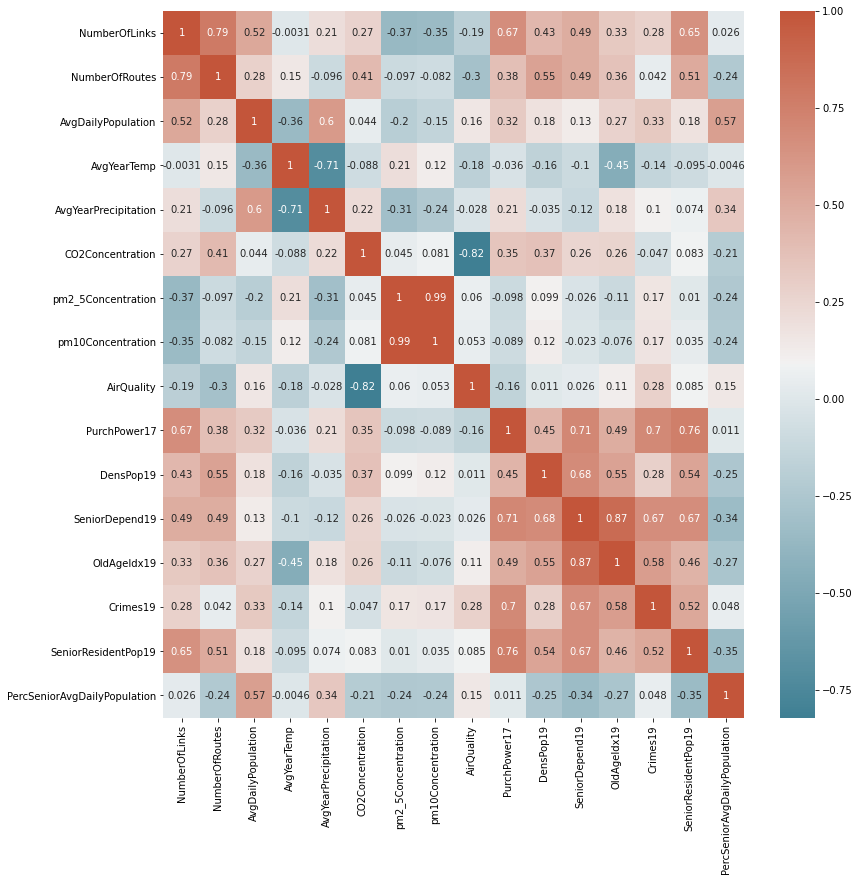

In [48]:
fig, ax = plt.subplots(figsize=(13,13)) 
corr = aggDf.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax)
#sns.pairplot(aggDf)

From the analysis of the correlation matrix, the following stand out:
- There is a positive correlation between the number of routes available and the number of links;
- There's also an overall positive correlation between the number of links and the ADSP.
- The ADSP correlates positively with the number of routes available. However, that correlation is not as big as the one related to links;
- As expected, the number of elder residents is correlated to the senior dependence and the last one with the aging index;
- One can also see a correlation between the number of elderly residents and the purchasing power, which may reflect a high number of elderly people with the financial ability to own a car;
- Theres a somewhat positive correlation between the precipitation and the number of senior citizens using public transports;
- Lastly, the percentage of seniors that use buses daily is inversely proportional to senior dependece, which means that the greater the number of elderly dependents in the county, the lower the number of elderly users.

/home/bsilva/anaconda3/envs/WDL/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bsilva/anaconda3/envs/WDL/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bsilva/anaconda3/envs/WDL/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bsilva/anaconda3/envs/WDL/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bsilva/anaconda3/envs/WDL/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/bsilva/anaconda3/envs/WDL/lib/python3.8/site-packages/

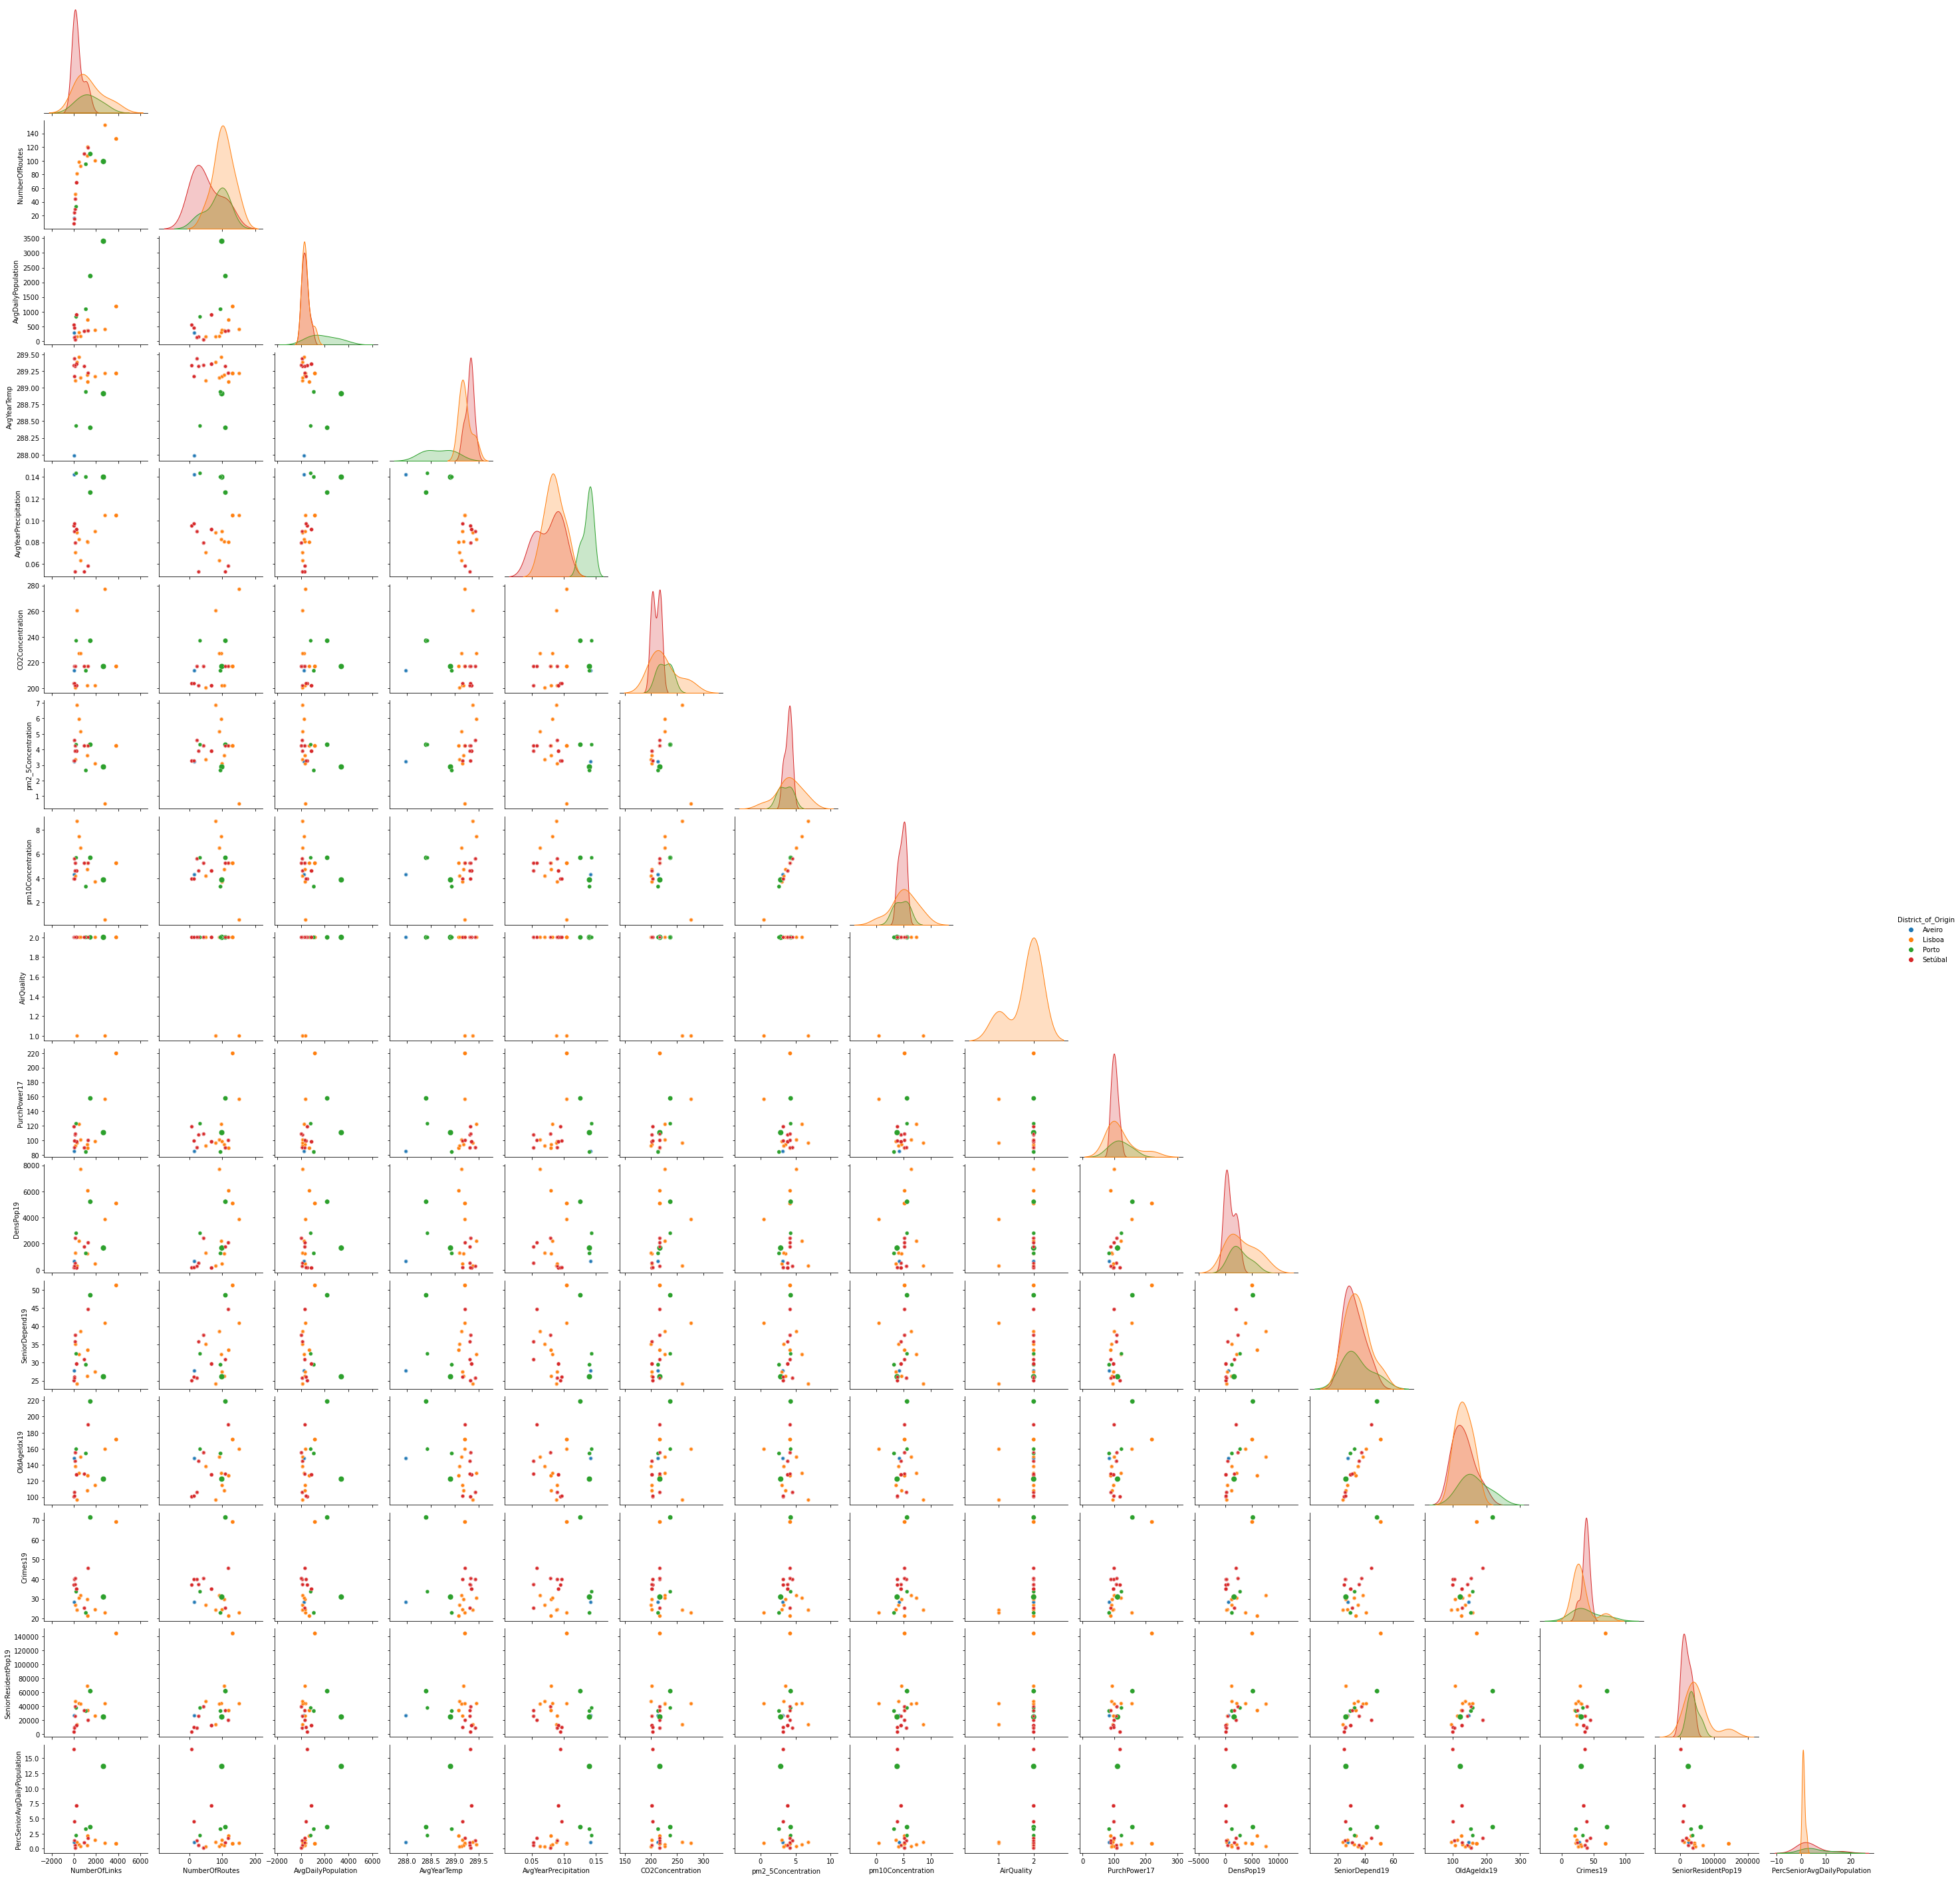

In [49]:
cols_red = cols_to_keep.copy()
cols_red.remove('District_of_Origin')
cols_red.remove('County_of_Origin')

g = sns.pairplot(aggDf, x_vars=cols_red, y_vars=cols_red, hue='District_of_Origin', corner=True)
g.map_offdiag(sns.scatterplot, size=aggDf['AvgDailyPopulation'])

In [50]:
cols_red.remove('AvgDailyPopulation') # pode dar erro se a célula for executada mais do que uma vez

## Correlation Matrix (per District)

In [51]:
def correlation(_df, city):
    df = _df.copy()
    corr = df.loc[df['District_of_Origin']==city]
    corr = corr.corr()

    return sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True,
                       cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [52]:
agg2Df= aggDf[['District_of_Origin', 'County_of_Origin', 'AvgDailyPopulation', 'NumberOfLinks', 'NumberOfRoutes',  'PurchPower17', 
       'DensPop19', 'SeniorDepend19',
       'SeniorResidentPop19', 'OldAgeIdx19', 'Crimes19', 
       'PercSeniorAvgDailyPopulation']]

agg2Df.columns

Index(['District_of_Origin', 'County_of_Origin', 'AvgDailyPopulation',
       'NumberOfLinks', 'NumberOfRoutes', 'PurchPower17', 'DensPop19',
       'SeniorDepend19', 'SeniorResidentPop19', 'OldAgeIdx19', 'Crimes19',
       'PercSeniorAvgDailyPopulation'],
      dtype='object')

### Porto

<AxesSubplot:>

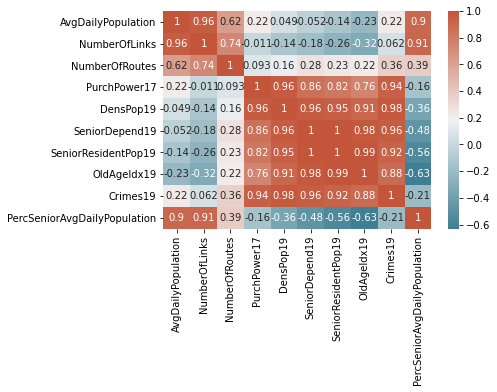

In [53]:
correlation(agg2Df,'Porto')

### Lisboa

<AxesSubplot:>

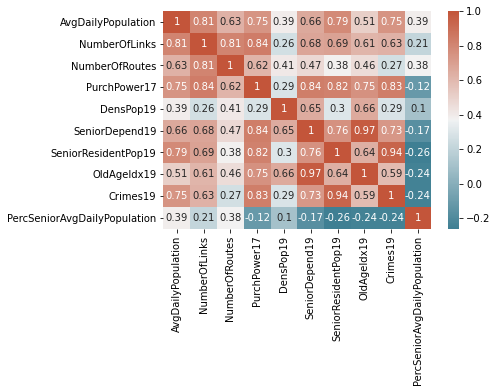

In [54]:
correlation(agg2Df,'Lisboa')

### Setúbal

<AxesSubplot:>

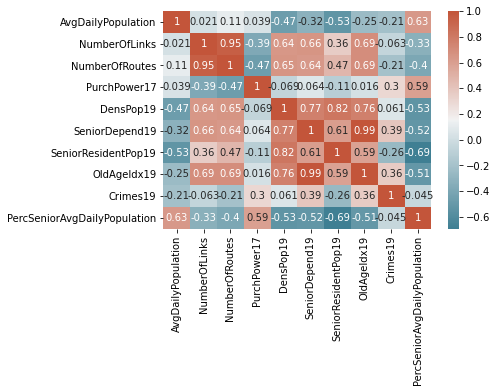

In [55]:
correlation(agg2Df,'Setúbal')

Analyzing the different districts:
- Porto: ADSP only highly correlates with the number of links and routes
- Lisboa: ADSP is closely correlated with purchasing power, senior dependence, number of crimes and number of senior residents
- Setúbal: ADSP does not correlate with any variable.

Hence it is concluded again that the behavior of mobility of the elderly is quite different between districts.

## Backward elimination

In [56]:
def backward_elimination(X, y, significance_level=0.05):
    cols = list(X.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>significance_level):
            print("Removing... " + feature_with_p_max)
            cols.remove(feature_with_p_max)
        else:
            break
    return cols

# with this significance level value we remain with 3 features
cols_red=['NumberOfLinks', 'NumberOfRoutes',  'PurchPower17', 
       'DensPop19', 'SeniorDepend19',
       'SeniorResidentPop19', 'OldAgeIdx19', 'Crimes19', 
       'PercSeniorAvgDailyPopulation']

cols = backward_elimination(agg2Df[cols_red], agg2Df['AvgDailyPopulation'],0.04)
cols = cols[0:3]
cols

Removing... NumberOfRoutes
Removing... SeniorResidentPop19
Removing... PurchPower17
Removing... DensPop19
Removing... Crimes19


['NumberOfLinks', 'SeniorDepend19', 'OldAgeIdx19']

#### We also performed PCA on data but it did not improve our results

## K-means

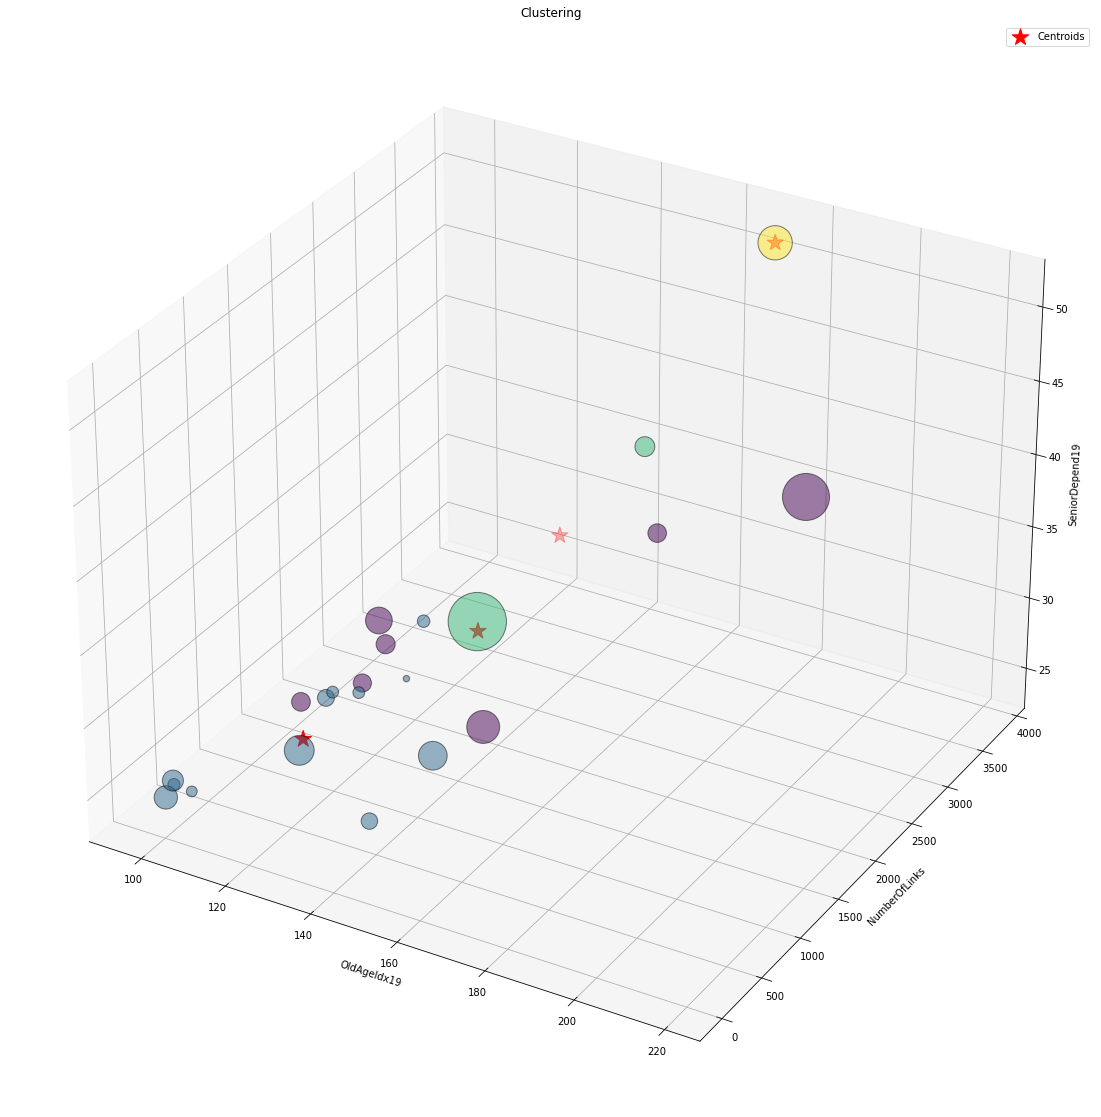

In [57]:
def kmeans_clustering(X_df, cols, nclusters, size, order):
    X = X_df[[cols[order[0]], cols[order[1]], cols[order[2]]]].to_numpy()
    
    kmeans= KMeans(n_clusters=nclusters, init='k-means++', max_iter= 500, n_init=10, random_state=0)
    y_kmeans = kmeans.fit_predict(X)

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(X[:,0],X[:,1],X[:,2], c=y_kmeans, edgecolor='k', 
               s=agg2Df['AvgDailyPopulation'].to_numpy(), alpha = 0.5)

    ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], 
               s = 300, c = 'r', marker='*', label = 'Centroids')

    plt.legend()
    ax.set_title("Clustering")
    ax.set_xlabel(cols[order[0]])
    ax.set_ylabel(cols[order[1]])
    ax.set_zlabel(cols[order[2]])

    plt.autoscale(enable=True, axis='x', tight=True)    

    plt.show()
    
kmeans_clustering(agg2Df[cols], cols, 4, agg2Df['AvgDailyPopulation'].to_numpy(), order=[2,0,1])

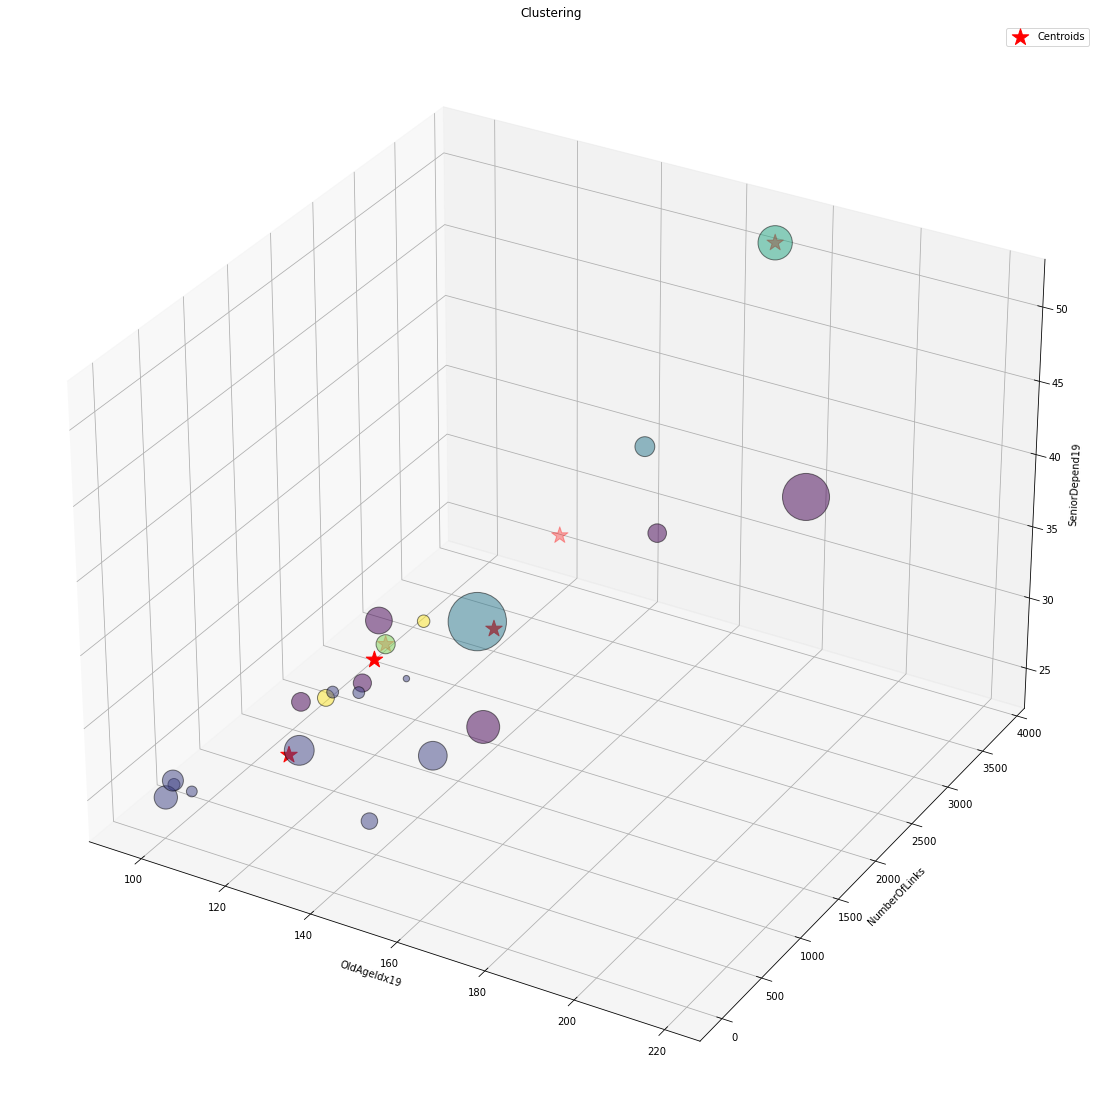

In [58]:
kmeans_clustering(agg2Df[cols], cols, 6, agg2Df['AvgDailyPopulation'].to_numpy(), order=[2,0,1])

## Visualizing data in 3D

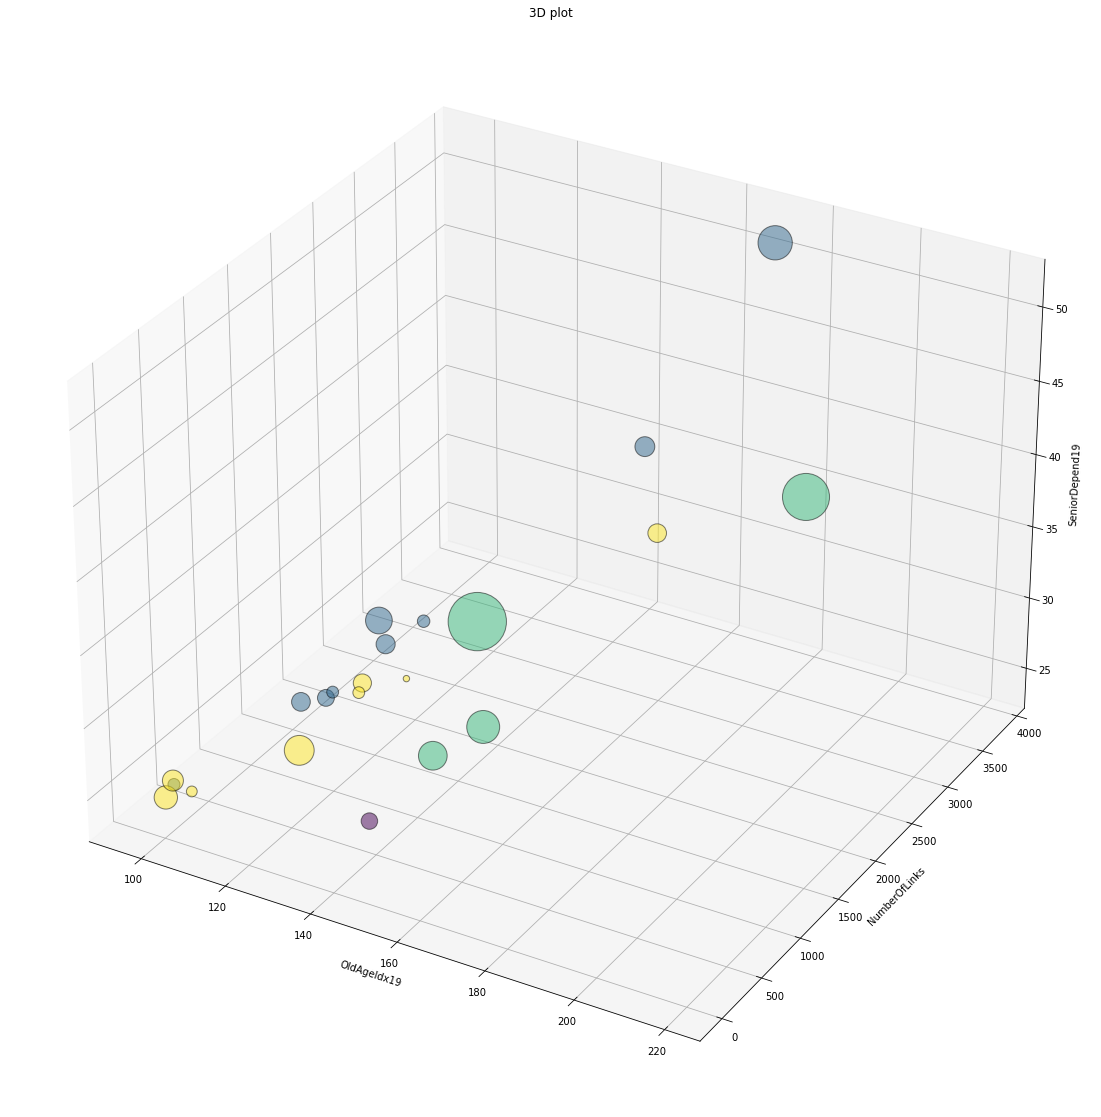

In [59]:
def plot_3d(X, cols, y, size, order):

    # the parameter order allow us to rotate the plot
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
           
    ax.scatter(X[:,order[0]],X[:,order[1]],X[:,order[2]], c=y, edgecolor='k', s=size, alpha = 0.5)

    #plt.legend()
    ax.set_title("3D plot")
    ax.set_xlabel(cols[order[0]])
    ax.set_ylabel(cols[order[1]])
    ax.set_zlabel(cols[order[2]])

    plt.autoscale(enable=True, axis='x', tight=True)    
    plt.show()
    
_df = agg2Df[['District_of_Origin']] \
        .replace('Aveiro', 0) \
        .replace('Lisboa', 1) \
        .replace('Porto', 2) \
        .replace('Setúbal', 3)
    
plot_3d(agg2Df[cols].to_numpy(), cols, _df.to_numpy(), agg2Df['AvgDailyPopulation'].to_numpy(), order=[2,0,1])

## Agglomerative clustering

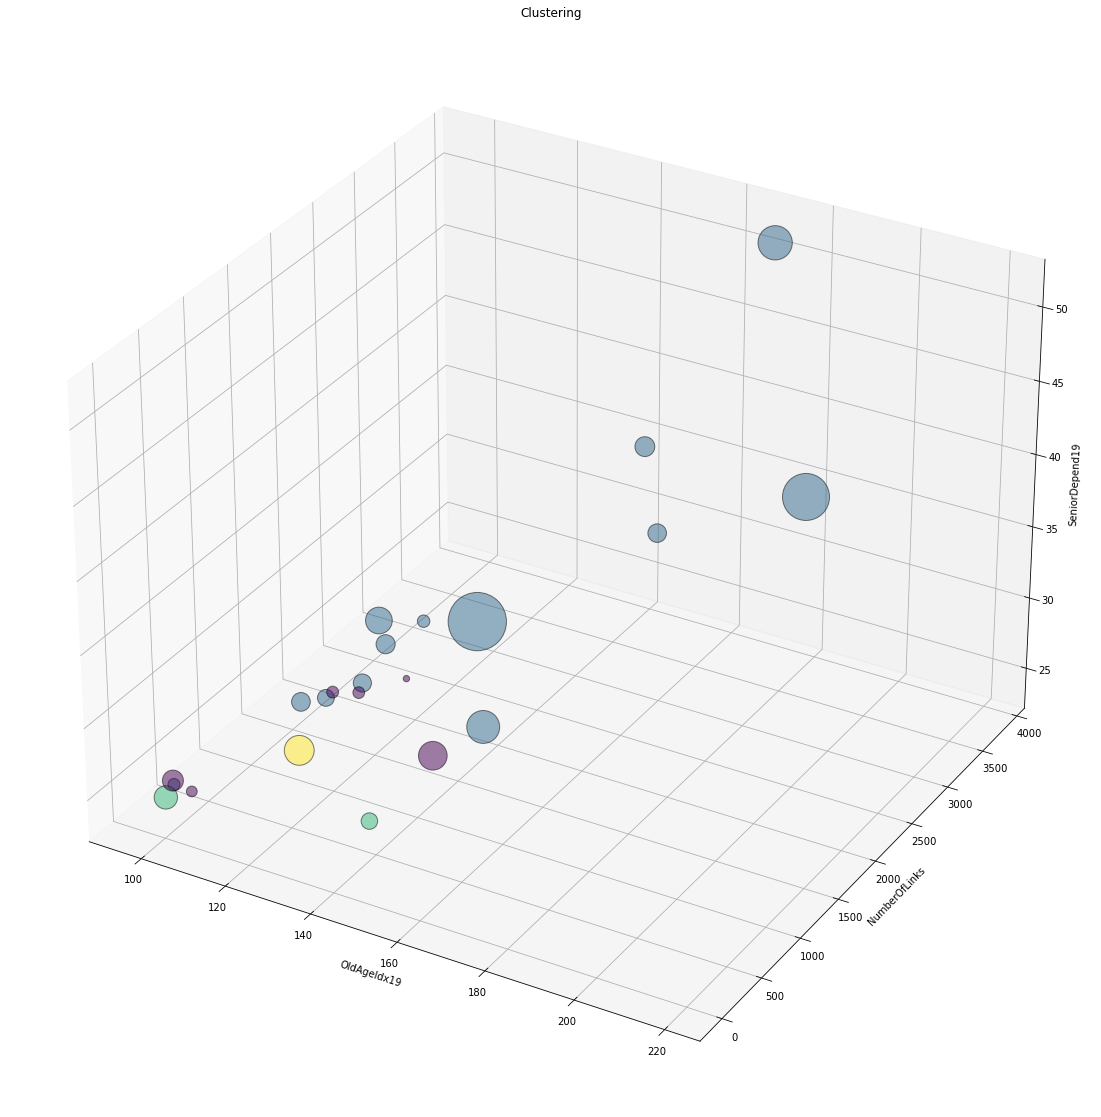

In [60]:
def agglomerative_clustering(X_df, cols, nclusters, size, order, metric):
    X = X_df[[cols[order[0]], cols[order[1]], cols[order[2]]]].to_numpy()
    
    model = AgglomerativeClustering(n_clusters=nclusters, linkage="average", affinity=metric)
    y_model = model.fit_predict(X)
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(X[:,0],X[:,1],X[:,2], edgecolor='k', c=y_model,
               s=agg2Df['AvgDailyPopulation'].to_numpy(), alpha = 0.5)

    #plt.legend()
    ax.set_title("Clustering")
    ax.set_xlabel(cols[order[0]])
    ax.set_ylabel(cols[order[1]])
    ax.set_zlabel(cols[order[2]])

    plt.autoscale(enable=True, axis='x', tight=True)    

    plt.show()
    
agglomerative_clustering(agg2Df[cols], cols, 4, agg2Df['AvgDailyPopulation'].to_numpy(), [2,0,1], 'cosine')

By visualizing the influence of 5 dependent variables (Old Age Index, Number of Links, Senior Dependency) with the District of Origin (color of the points) and the ADSP (size of the points), we cannot identify any cluster of relevant points. We've also tried to rotate the axis, but didn't help.  

## Linear regression model for predicting Average Daily Senior Population

In [61]:
scaler = MinMaxScaler(feature_range=(0, 1))



# split into train and test
df_train, df_test = train_test_split(agg2Df, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 10)

X_train = df_train.iloc[:, list(range(3, 12))]
X_train = scaler.fit_transform(X_train)
y_train = df_train.iloc[:, 2]

X_test = df_test.iloc[:, list(range(3, 12))]
X_test = scaler.fit_transform(X_test)
y_test = df_test.iloc[:, 2]

In [62]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

hyper_params = [{'n_features_to_select': list(range(1, 9))}]

lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'neg_mean_squared_error', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

model_cv.fit(X_train, np.log(y_train))     

scores = cross_val_score(model_cv, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores.mean()

print('Best Score: ', model_cv.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score:  -1.5182407539441456


In [63]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.005091,0.000567,0.000446,0.000046,1,{'n_features_to_select': 1},-0.114191,-2.186603,-1.738179,-3.064671,...,-1.518241,1.088135,1,-1.174486,-0.806730,-0.443398,-0.980199,-1.229021,-0.926767,0.284124
1,0.004074,0.000170,0.000381,0.000029,2,{'n_features_to_select': 2},-0.120413,-7.614561,-1.549174,-10.549669,...,-4.058962,4.231504,5,-1.068905,-0.547692,-0.405852,-0.545164,-1.227755,-0.759074,0.325841
2,0.003559,0.000175,0.000366,0.000018,3,{'n_features_to_select': 3},-0.229378,-9.183285,-1.993336,-8.856317,...,-4.084458,4.084231,6,-0.709801,-0.471101,-0.330295,-0.496345,-1.183552,-0.638219,0.298458
3,0.003257,0.000316,0.000371,0.000023,4,{'n_features_to_select': 4},-2.040219,-8.891695,-2.615070,-4.527530,...,-4.250352,2.462896,7,-0.261730,-0.261769,-0.151683,-0.372352,-0.415007,-0.292508,0.092849
4,0.002523,0.000029,0.000337,0.000021,5,{'n_features_to_select': 5},-0.739804,-11.082742,-2.382792,-2.770198,...,-3.912600,3.657293,4,-0.167124,-0.191280,-0.109860,-0.369231,-0.372616,-0.242022,0.108525
5,0.002210,0.000125,0.000365,0.000056,6,{'n_features_to_select': 6},-0.814345,-10.351346,-2.031676,-1.961832,...,-3.548611,3.449728,2,-0.146459,-0.190877,-0.062108,-0.359347,-0.372601,-0.226278,0.121404
6,0.001680,0.000014,0.000325,0.000014,7,{'n_features_to_select': 7},-0.741352,-13.450670,-1.970954,-0.686507,...,-3.699339,4.901303,3,-0.138851,-0.136179,-0.058558,-0.230577,-0.126302,-0.138093,0.054813
7,0.001371,0.000194,0.000333,0.000028,8,{'n_features_to_select': 8},-0.790040,-21.013674,-1.975404,-0.584768,...,-5.212753,7.917935,8,-0.138117,-0.129077,-0.058086,-0.226495,-0.124988,-0.135353,0.053725


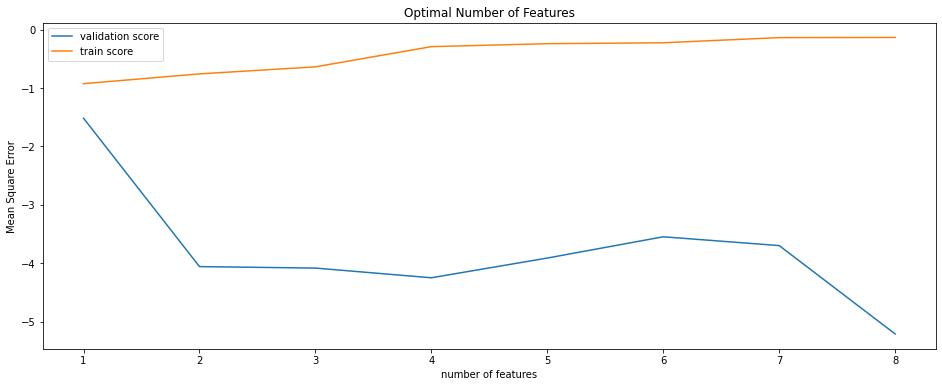

In [64]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('Mean Square Error')
plt.title("Optimal Number of Features")
plt.legend(['validation score', 'train score'], loc='upper left')

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_predicted=np.exp(model_cv.predict(X_test))

truthPredARrr = np.array([y_test, y_predicted])

print ("Mean Squared Error (MSE): {}".format(mean_squared_error(y_test, y_predicted, squared=True)))
print ("Mean Absolute Error (MAE): {}".format(mean_absolute_error(y_test, y_predicted)))

Mean Squared Error (MSE): 315758.3665037553
Mean Absolute Error (MAE): 471.1163249692741


In [66]:
dfPred = pd.DataFrame(truthPredARrr)
dfPred=dfPred.T
dfPred.columns= ['Ground Truth Average Daily Senior Citizens','Predicted Average Daily Senior Citizens']

dfPred

,Ground Truth Average Daily Senior Citizens,Predicted Average Daily Senior Citizens
0,889.849297,334.031218
1,351.236967,305.119530
2,715.200512,273.709296
3,2213.490123,1290.012825
4,155.706508,353.476229
5,138.546544,413.220753
6,394.144009,1252.610323


By observing the results, we conclude that our model is not sufficiently accurate to predict the Average Daily Senior Population

## Conclusions
Overall, we can conclude that of all the variables used, those that most correlate with the average daily senior population (ADSP) are the number of links and routes.

However, in a more detailed analysis in which only one district is considered, some differences were detected, as in the case of Lisboa, in which there are other variables that also correlate with ADSP, namely purchasing power, senior dependence, number of crimes and number of senior residents. In Porto, correlation is restricted to the number of links and routes and in Setúbal there is no correlation. As there was only one data point in Aveiro, we could not perform an extensive analysis on it.

Therefore, we can conclude that the mobility of the elderly is quite different from district to district and, the variables we used do not have the same influence for all locations. Possibly a better approach would be to adapt the variables in the model to the district being considered, however in this approach we would have to have much more data.

Furthermore, Co2 concentration increases on cities with
more routes, which may indicate that current public transportations are not very eco friendly. However, those cities also have more cars and population which may be the reason for that increase. 

### Future Work

Some of the main reasons why the elderly do not use public transport are related to the distance from their home to the stop of origin and from the stop of destination to the destiny, the overcrowding of transport and also the quality of it.

If it were possible to have access to the coordinates of residences or areas mostly occupied by the elderly, and also to the coordinates of routes and stops in those areas, it would be possible to relate the distance from residences to stops and thus identify the areas where it was necessary to increase the number of stops.

With access to the times of overcrowding of transports and including the previous information, could be created a model capable of indicating the times and zones when there was the greatest influx and thus increase the number of transports in circulation in that area at that time, so that the elderly feel comfortable when using them.

Furthermore, knowing the quality of transport in the areas and the number of elderly people using them, we could predict which areas must have an intervention in order to improve transports' conditions.

One should also consider that senior people may not use public transportation if they generate a lot of polution, either for health reasons or due to environment concerns. Therefore, one should further study what is the perceived concerns about air polution within the senior citizens population.

Finally, having access to the destination county and the reason they are using public transport, added to the information from the given data, would be very important to understand the daily life of the elderly, in the perspective of knowing which activities they perform the most. For example, if there was a county in which many of the elderly used public transport to go to the hospital in another county, some conclusions could be drawn such as their county of residence has few health services and therefore there may be a need to increase them or, we could even conclude that there is a need to ensure several travel times for the elderly to travel to the hospital when necessary.


## References

[1]	S. Srichuae, V. Nitivattananon, and R. Perera, “Aging society in Bangkok and the factors affecting mobility of elderly in urban public spaces and transportation facilities,” IATSS Res., vol. 40, no. 1, pp. 26–34, 2016, doi: 10.1016/j.iatssr.2015.12.004.

[2]	G. A. Azevedo, R. R. Sampaio, A. S. N. Filho, M. A. Moret, and T. B. Murari, “Sustainable urban mobility analysis for elderly and disabled people in São Paulo,” Sci. Rep., vol. 11, no. 1, pp. 1–10, 2021, doi: 10.1038/s41598-020-80906-w.

[3]	PORDATA, “População residente, estimativas a 31 de Dezembro: total e por grupo etário.”, Available: https://www.pordata.pt/Municipios/População+residente++estimativas+a+31+de+Dezembro+total+e+por+grupo+etário-137.

[4]	PORDATA, “Índice de envelhecimento,”, Available: https://www.pordata.pt/Municipios/Índice+de+envelhecimento-458.

[5]	PORDATA, “Poder de compra per capita,”, Available: https://www.pordata.pt/Municipios/Poder+de+compra+per+capita-118.

[6]	PORDATA, “Crimes registados pelas polícias por mil habitantes.”, Available: https://www.pordata.pt/Municipios/Crimes+registados+pelas+polícias+por+mil+habitantes-995.

[7]	PORDATA, “Índice de dependência de idosos,”, Available: https://www.pordata.pt/Municipios/Índice+de+dependência+de+idosos-461.

[8] OpenWeather, “OpenWeather.” https://openweathermap.org/.